# Implementación de una red neural para predecir si un cliente tiene contratada la factura digital de la luz

### Autor: Roberto Maeso Benito
Junio 2021

**Breve descripción**: Problema de clasificación en el que, a partir de una base de datos de una compañia eléctrica con datos sociodemográficos sobre sus clientes, se busca predecir cuando un cliente tiene contratada la factura digital o eléctronica. En total, se cuenta con un total de 10 atributos (además del target):

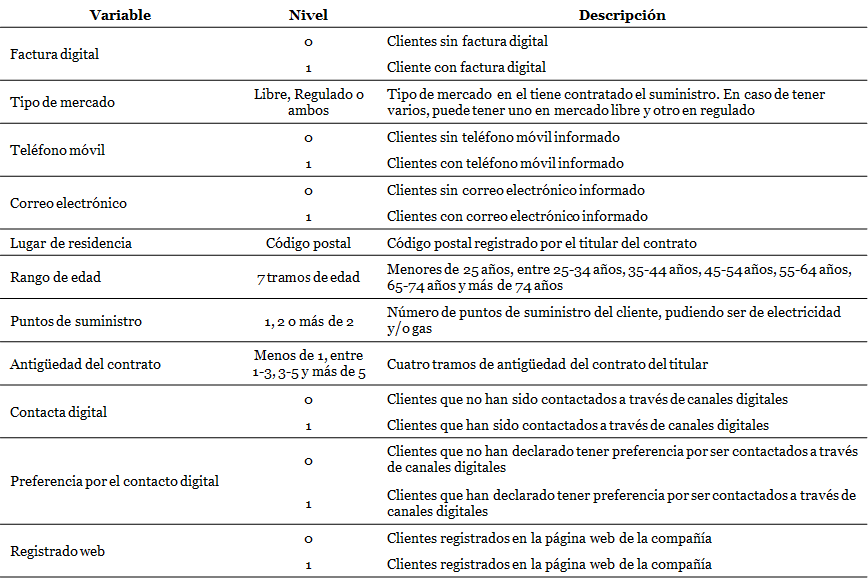

Por temas regulatorios, se separa esta base de datos en dos: una para los clientes que se encuentran en mercado libre y otra para los clientes de mercado regulado (por ley no se puede transferir información de un mercado a otro). Los análisis mostrados a continuación se llevan a cabo para el mercado libre, aunque pueden ser facilmente adaptados al mercado regulado.

### Tabla de contenidos  <a name="indice"></a>

- [Importing libraries and loading dataset](#data)
- [Exploratory Data Analysis](#eda)
- [Feature engineering](#fe)
- [Modeling - NN](#nn)
    - [1º NN Architecture](#1nn)
    - [2º NN Architecture](#2nn)
    - [3º NN Architecture](#3nn)
- [Hyperparameter tuning](#hpt)
- [Conclusion](#conclusion)

### Importing libraries and loading dataset<a name="data"></a> 
[Volver al índice](#indice)

In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import optimizers

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import shap
import ipywidgets as widgets

%matplotlib inline

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


### Exploratory Data Analysis<a name="eda"></a> 
[Volver al índice](#indice)

In [2]:
df = pd.read_csv("datalibre_clean.csv", sep = ',', header=0,index_col=False)
target = 'sd_factura_digital'
del df['Unnamed: 0']
df.head()

,sd_tfnmovil,sd_email,sd_registrado_ec,sd_factura_digital,sd_cta_prefer_online,sd_ctacta_digital,rango_edad_25_34,rango_edad_35_44,rango_edad_45_54,rango_edad_55-64.,rango_edad_65_74,rango_edad_higher_74,rango_edad_lower_25,antig_lower_1,antig_5,antig_1_3,antig_3_5,PS_higher_2,PS_1,PS_2
0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
2,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
3,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0
4,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0


In [3]:
# check data shape
print(df.shape)
# check missing data. If missing data, action is need it
df.isna().sum()

(3560839, 20)


sd_tfnmovil             0
sd_email                0
sd_registrado_ec        0
sd_factura_digital      0
sd_cta_prefer_online    0
sd_ctacta_digital       0
rango_edad_25_34        0
rango_edad_35_44        0
rango_edad_45_54        0
rango_edad_55-64.       0
rango_edad_65_74        0
rango_edad_higher_74    0
rango_edad_lower_25     0
antig_lower_1           0
antig_5                 0
antig_1_3               0
antig_3_5               0
PS_higher_2             0
PS_1                    0
PS_2                    0
dtype: int64

In [4]:
# check data format
df.dtypes

sd_tfnmovil             int64
sd_email                int64
sd_registrado_ec        int64
sd_factura_digital      int64
sd_cta_prefer_online    int64
sd_ctacta_digital       int64
rango_edad_25_34        int64
rango_edad_35_44        int64
rango_edad_45_54        int64
rango_edad_55-64.       int64
rango_edad_65_74        int64
rango_edad_higher_74    int64
rango_edad_lower_25     int64
antig_lower_1           int64
antig_5                 int64
antig_1_3               int64
antig_3_5               int64
PS_higher_2             int64
PS_1                    int64
PS_2                    int64
dtype: object

No existen missing values y todas las variable son númericas

In [5]:
df.describe()

,sd_tfnmovil,sd_email,sd_registrado_ec,sd_factura_digital,sd_cta_prefer_online,sd_ctacta_digital,rango_edad_25_34,rango_edad_35_44,rango_edad_45_54,rango_edad_55-64.,rango_edad_65_74,rango_edad_higher_74,rango_edad_lower_25,antig_lower_1,antig_5,antig_1_3,antig_3_5,PS_higher_2,PS_1,PS_2
count,3.560839e+06,3.560839e+06,3.560839e+06,3.560839e+06,3.560839e+06,3.560839e+06,3.560839e+06,3.560839e+06,3.560839e+06,3.560839e+06,3.560839e+06,3.560839e+06,3.560839e+06,3.560839e+06,3.560839e+06,3.560839e+06,3.560839e+06,3.560839e+06,3.560839e+06,3.560839e+06
mean,7.962348e-01,5.773878e-01,3.390035e-01,3.322203e-01,2.627322e-01,3.030603e-01,4.285001e-02,1.820391e-01,2.429913e-01,1.976655e-01,1.636311e-01,1.708224e-01,5.616654e-07,9.760930e-02,5.942448e-01,1.589347e-01,1.492112e-01,5.001911e-02,7.052588e-01,2.447221e-01
std,4.027964e-01,4.939749e-01,4.733711e-01,4.710096e-01,4.401182e-01,4.595811e-01,2.025189e-01,3.858768e-01,4.288900e-01,3.982385e-01,3.699405e-01,3.763537e-01,7.494433e-04,2.967857e-01,4.910377e-01,3.656153e-01,3.562966e-01,2.179844e-01,4.559264e-01,4.299224e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
75%,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


### Featuring engineering<a name="fe"></a> 
[Volver al índice](#indice)

Sobre la base de datos original se han aplicado técnicas de hot-encoding por lo que no es necesario realizar ninguna acción adicional antes de empezar a modelizar

### Modeling - NN<a name="nn"></a> 
[Volver al índice](#indice)

Antes de empezar a modelizar creamos las siguientes funciones:
- plot_history_train para entender los resultados del modelo sobre los datos de entrenamiento
- plot_history para entender las métricas de precision y error de nuestro modelo para cada época
- plot_confussion_matrix para graficar la matriz de confusión con los resultados del modelo


In [6]:
import matplotlib.pyplot as plt

def plot_history_train(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [7]:
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_history(history):
    metrics =  ['loss', 'accuracy']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], color=colors[1]
                 #, linestyle="-"
                 , label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.0,1])
        else:
            plt.ylim([0,1])

    plt.legend()

In [8]:
import seaborn as sns

def plot_confussion_matrix(y_true, y_pred, classes, size = 5):

    con_mat = tf.math.confusion_matrix(labels = y_true
                                       , predictions = y_pred).numpy()
    classes = classes.keys()
    #con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis = 1)[:, np.newaxis], decimals = 5)
    con_mat_df = pd.DataFrame(con_mat
                              , index = classes
                              , columns = classes)

    figure = plt.figure(figsize=(size, size))
    sns.heatmap(con_mat_df
                , annot=True
                , fmt=".1f"
                , xticklabels = classes
                , yticklabels = classes
                #, cmap=plt.cm.Blues
                )
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Comenzamos definiendo una serie de parámetros (posteriormente valideramos si son los más adecuados)

In [9]:
# parametrization
test_size = 0.5
val_size = 0.3
epochs = 10
batch_size = 128

Separamos la base de datos en entranmiento y validación y convertimos las variables dependientes e independientes a np.array

In [10]:
df = df.sample(frac=1)
train_df, test_df = train_test_split(df
                                     , test_size = test_size, random_state=0)
train_df, val_df = train_test_split(train_df
                                    , test_size = val_size, random_state=0)

# Form np arrays of labels and features.
train_features = np.array(train_df[train_df.columns.difference([target])])
val_features = np.array(val_df[val_df.columns.difference([target])])
test_features = np.array(test_df[test_df.columns.difference([target])])

train_labels = np.array(train_df[[target]])
val_labels = np.array(val_df[[target]])
test_labels = np.array(test_df[[target]])

input_len = train_features.shape[1]

shap_test_df = test_df.copy(deep = True)

Definimos también las funciones de recall y precisión para irlas llamando a medida que realicemos el entrenamiento del modelo

In [11]:
from keras import backend as K

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [12]:
from keras import layers, initializers

Creamos el modelo de NN lo más dinámico posible para luego ir optimizando los parámetros. Partiendo del modelo visto en clase incluimos mayor flexibilidad en los optimizadores, para poder elegir el Adam y el SGD de forma adicional al RMSprop.

In [13]:
def make_model(dense_layers = 1
               , dense_dropout = 0.0
               , RMS = 0.01
               , verbose = True):
    
    # creamos el modelo, loop con las capas seleccionadas
    model = Sequential()
    for i in range(0,dense_layers):
        model.add(Dense(units = input_len
                        , input_dim = input_len
                        , kernel_initializer='normal'
                        , activation='relu'))

    model.add(Dense(len(df[target].unique()), activation='softmax', kernel_initializer='random_uniform'))
    # Definimos diferentes optimizadores
    opt_RMSprop = tf.keras.optimizers.RMSprop(RMS) 
    # Compile el modelo
    model.compile(optimizer = opt_RMSprop
                  , loss='sparse_categorical_crossentropy' # problema de clasificación 1/0
                  , metrics=['accuracy', precision, recall]) # métricas de interes para evaluar el modelo
    if verbose:
        print('dense_layers :' + str(dense_layers))
        print('RMS :' + str(RMS))
        print(model.summary())
        
    return model

### 1º NN Architecture

In [14]:
firstnnmodel = make_model(dense_layers = 5)
firstnnmodel.summary()

dense_layers :5
RMS :0.01
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 19)                380       
_________________________________________________________________
dense_1 (Dense)              (None, 19)                380       
_________________________________________________________________
dense_2 (Dense)              (None, 19)                380       
_________________________________________________________________
dense_3 (Dense)              (None, 19)                380       
_________________________________________________________________
dense_4 (Dense)              (None, 19)                380       
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 40        
Total params: 1,940
Trainable params: 1,940
Non-trainable params: 0
____________________________

In [15]:
history_firstnnmodel = firstnnmodel.fit(train_features,
                    train_labels,
                    batch_size = batch_size,
                    epochs = epochs,
                    validation_data = (val_features, val_labels), 
                    verbose = 1)

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpggdybezw.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpggdybezw.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
9737/9737 [==============================] - 36s 2ms/step - loss: 0.2326 - accuracy: 0.9074 - precision: 0.3326 - recall: 1.0000 - val_loss: 0.2245 - val_accuracy: 0.9118 - val_precision: 0.3317 - val_recall: 1.0000
Epoch 2/10
9737/9737 [==============================] - 15s 2ms/step - loss: 0.2254 - accuracy: 0.9101 - precision: 0.3330 - recall: 1.0000 - val_loss: 0.2237 - val_accu

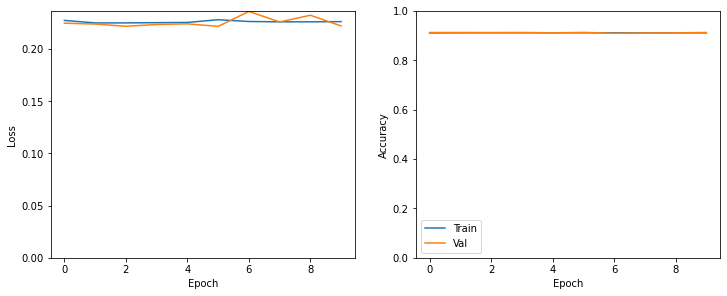

In [16]:
plot_history(history_firstnnmodel)

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


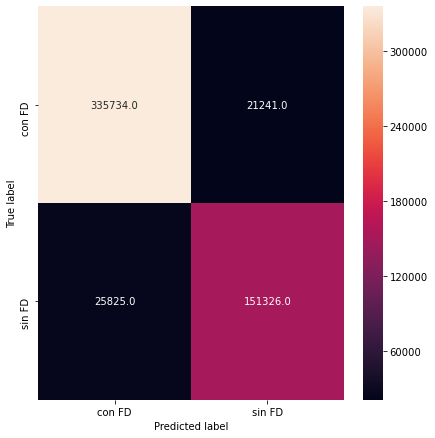

In [17]:
dead_dict = {'con FD':1, 'sin FD':0}
classes = dead_dict
y_pred = firstnnmodel.predict_classes(val_features)

plot_confussion_matrix(y_true = val_labels, y_pred = y_pred, classes = classes, size = 6)

Mostramos algunas metricas relevantes calculadas a partir de la matriz de confusión

In [18]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import cohen_kappa_score
conf_mat = confusion_matrix(y_true=val_labels, y_pred=y_pred)

# calculamos las diferentes métricas a partir de la matriz de confusión
total1=sum(sum(conf_mat))
accuracy1=(conf_mat[0,0]+conf_mat[1,1])/total1
print ('Accuracy : ', accuracy1)

sensitivity1 = conf_mat[0,0]/(conf_mat[0,0]+conf_mat[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = conf_mat[1,1]/(conf_mat[1,0]+conf_mat[1,1])
print('Specificity : ', specificity1)

kappa = cohen_kappa_score(y_pred,val_labels)
print('Kappa : ', kappa)

Accuracy :  0.9118822150578703
Sensitivity :  0.940497233699839
Specificity :  0.8542204108359535
Kappa :  0.7999311938931208


Como se puede apreciar en los gráficos el modelo no está aprendiendo a medida que incrementamos el número de epocas. No osbtante, obtenemos niveles de precisión (accuracy) superiores al 91,2%. Para esta primera aquitectura también se prueba la libreria shap donde se puede entender de forma intutiva como está influyendo cada variable al modelo (en el resto de arquitecturas nos se ha incluido ya que los resultados son similares).

In [19]:
explainer_size = 50 # numer of data points to be considered in explainer. 
shap_values_size = 1
nsamples = 100 # 
current_label = 0 # from 0 to n-1 where n is number of target variables

df_features = shap_test_df[shap_test_df.columns.difference([target])]
                                 
explainer = shap.KernelExplainer(model = firstnnmodel.predict
                                 , data = df_features.head(explainer_size)
                                 , link = "identity")

#explainer_size might be shap_values_size
shap_values=explainer.shap_values(X = df_features.iloc[0:explainer_size,:] 
                                    , nsamples = nsamples)

  0%|          | 0/50 [00:00<?, ?it/s]

In [20]:
shap.initjs()

shap.force_plot(base_value = explainer.expected_value[current_label],
                shap_values = shap_values[current_label],
                features = df_features.iloc[0:explainer_size,:]
                )

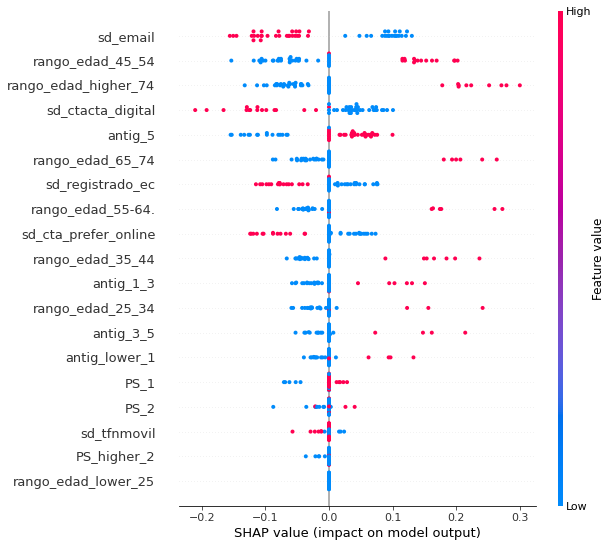

In [21]:
shap.initjs()

# top to bottom represent feature relevance
# blue values represent low values in feature
# red values represent high values in feature
# left axis values represent negative shap, negative weight to prediction
# right axis values represent positive shap, positive weight to prediction

shap.summary_plot(shap_values = shap_values[current_label],
                  features = df_features.iloc[0:explainer_size,:]
                  )

A continuación se prueban otras arquitecturas de NN.

### 2º NN Architecture<a name="2nn"></a> 
[Volver al índice](#indice)

Ahora probamos una segunda arquitectura de NN. En esta segunda arquitectura mantenemos el número de epocas (ya que el modelo no parece aprender a medida que pasan las epocas) pero incrementamos el número de capas a 10. Asimismo y para asegurar que no estamos overfitting los datos de entrenamiento introducimos un nivel de **dropout**.

In [22]:
secondnnmodel = make_model(dense_layers = 10 , dense_dropout = 0.5)
secondnnmodel.summary()

dense_layers :10
RMS :0.01
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 19)                380       
_________________________________________________________________
dense_7 (Dense)              (None, 19)                380       
_________________________________________________________________
dense_8 (Dense)              (None, 19)                380       
_________________________________________________________________
dense_9 (Dense)              (None, 19)                380       
_________________________________________________________________
dense_10 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_11 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_12 (Dense)           

Epoch 1/10
9737/9737 [==============================] - 23s 2ms/step - loss: 0.2433 - accuracy: 0.9039 - precision: 0.3324 - recall: 0.9990 - val_loss: 0.2257 - val_accuracy: 0.9116 - val_precision: 0.3317 - val_recall: 1.0000
Epoch 2/10
9737/9737 [==============================] - 19s 2ms/step - loss: 0.2273 - accuracy: 0.9098 - precision: 0.3328 - recall: 1.0000 - val_loss: 0.2223 - val_accuracy: 0.9120 - val_precision: 0.3317 - val_recall: 1.0000
Epoch 3/10
9737/9737 [==============================] - 18s 2ms/step - loss: 0.2273 - accuracy: 0.9103 - precision: 0.3327 - recall: 1.0000 - val_loss: 0.2232 - val_accuracy: 0.9093 - val_precision: 0.3317 - val_recall: 1.0000
Epoch 4/10
9737/9737 [==============================] - 20s 2ms/step - loss: 0.2294 - accuracy: 0.9101 - precision: 0.3325 - recall: 1.0000 - val_loss: 0.2273 - val_accuracy: 0.9114 - val_precision: 0.3317 - val_recall: 1.0000
Epoch 5/10
9737/9737 [==============================] - 17s 2ms/step - loss: 0.2269 - accura

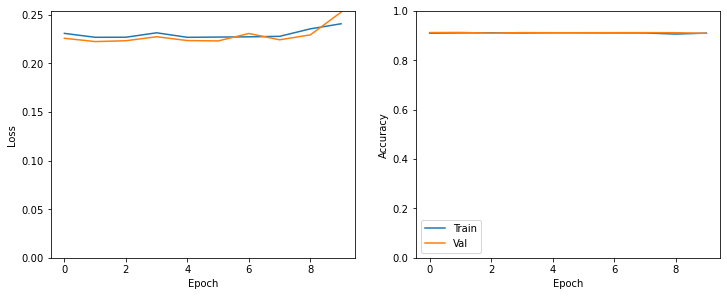

In [23]:
history_secondnnmodel = secondnnmodel.fit(train_features,
                    train_labels,
                    batch_size = batch_size,
                    epochs = epochs,
                    validation_data = (val_features, val_labels), 
                    verbose = 1)
plot_history(history_secondnnmodel)

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


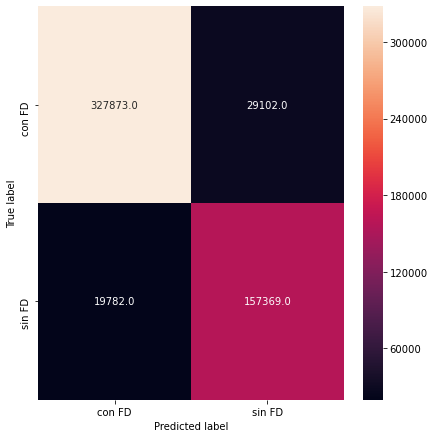

In [24]:
y_pred_secondnnmodel = secondnnmodel.predict_classes(val_features)
plot_confussion_matrix(y_true = val_labels, y_pred = y_pred_secondnnmodel, classes = classes, size = 6)

In [25]:
conf_mat_secondnnmodel = confusion_matrix(y_true=val_labels, y_pred=y_pred_secondnnmodel)
# calculamos las diferentes métricas a partir de la matriz de confusión
total1_secondnnmodel=sum(sum(conf_mat_secondnnmodel))
accuracy1_secondnnmodel=(conf_mat_secondnnmodel[0,0]+conf_mat_secondnnmodel[1,1])/total1_secondnnmodel
print ('Accuracy : ', accuracy1_secondnnmodel)
sensitivity1_secondnnmodel = conf_mat_secondnnmodel[0,0]/(conf_mat_secondnnmodel[0,0]+conf_mat_secondnnmodel[0,1])
print('Sensitivity : ', sensitivity1_secondnnmodel )
specificity1_secondnnmodel = conf_mat_secondnnmodel[1,1]/(conf_mat_secondnnmodel[1,0]+conf_mat_secondnnmodel[1,1])
print('Specificity : ', specificity1_secondnnmodel)
kappa_secondnnmodel = cohen_kappa_score(y_pred_secondnnmodel,val_labels)
print('Kappa : ', kappa_secondnnmodel)

Accuracy :  0.9084785237940112
Sensitivity :  0.918476083759367
Specificity :  0.88833255245525
Kappa :  0.7962573449556665


Los resultados se mantienen bastante similares a los obtenidos con la primera arquitectura. Un alto número de capas no parece incrementar la precisión del modelo.

### 3º NN Architecture<a name="3nn"></a> 
[Volver al índice](#indice)

En esta tercera estructura mantenemos las capas de la NN y cambiamos nuestro optimizador a SGD para ver si es capaz de generalizar mejor los datos. En la parte del final se realiza un ajuste de hiperamtros en el que se probarán, entre otros parámetros, diferentes learning rates (ahora se usa en todos 0.01)

In [28]:
from keras.optimizers import SGD

def make_model_SGD(dense_layers = 1
               , dense_dropout = 0.0
               , lr = 0.01
               , decay=1e-4
               , verbose = True):
    
    # creamos el modelo, loop con las capas seleccionadas
    model = Sequential()
    for i in range(0,dense_layers):
        model.add(Dense(units = input_len
                        , input_dim = input_len
                        , kernel_initializer='normal'
                        , activation='relu'))

    model.add(Dense(len(df[target].unique()), activation='softmax', kernel_initializer='random_uniform'))
    # Definimos diferentes optimizadores
    opt_SGD = SGD(learning_rate=lr,decay=decay)
    # Compile el modelo
    model.compile(optimizer = opt_SGD
                  , loss='sparse_categorical_crossentropy' # problema de clasificación 1/0
                  , metrics=['accuracy', precision, recall]) # métricas de interes para evaluar el modelo
    if verbose:
        print('dense_layers :' + str(dense_layers))
        print('RMS :' + str(lr))
        print(model.summary())
        
    return model

Se ha incrementado el learning rate del modelo para poder obtener resultados similares a las arquitecturas anteriores

In [29]:
thirdnnmodel = make_model_SGD(dense_layers = 5, lr = 0.1)
thirdnnmodel.summary()

dense_layers :5
RMS :0.1
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_24 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_25 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_26 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_27 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_28 (Dense)             (None, 2)                 40        
Total params: 1,940
Trainable params: 1,940
Non-trainable params: 0
___________________________

Epoch 1/10
9737/9737 [==============================] - 17s 2ms/step - loss: 0.6367 - accuracy: 0.6669 - precision: 0.3328 - recall: 1.0000 - val_loss: 0.6353 - val_accuracy: 0.6683 - val_precision: 0.3317 - val_recall: 1.0000
Epoch 2/10
9737/9737 [==============================] - 16s 2ms/step - loss: 0.5543 - accuracy: 0.7152 - precision: 0.3330 - recall: 1.0000 - val_loss: 0.2225 - val_accuracy: 0.9117 - val_precision: 0.3317 - val_recall: 1.0000
Epoch 3/10
9737/9737 [==============================] - 16s 2ms/step - loss: 0.2250 - accuracy: 0.9101 - precision: 0.3330 - recall: 1.0000 - val_loss: 0.2215 - val_accuracy: 0.9118 - val_precision: 0.3317 - val_recall: 1.0000
Epoch 4/10
9737/9737 [==============================] - 18s 2ms/step - loss: 0.2234 - accuracy: 0.9110 - precision: 0.3321 - recall: 1.0000 - val_loss: 0.2223 - val_accuracy: 0.9110 - val_precision: 0.3317 - val_recall: 1.0000
Epoch 5/10
9737/9737 [==============================] - 15s 2ms/step - loss: 0.2230 - accura

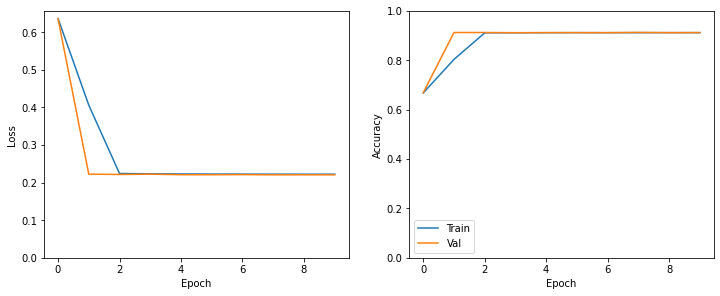

In [30]:
history_thirdnnmodel = thirdnnmodel.fit(train_features,
                    train_labels,
                    batch_size = batch_size,
                    epochs = epochs,
                    validation_data = (val_features, val_labels), 
                    verbose = 1)
plot_history(history_thirdnnmodel)

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


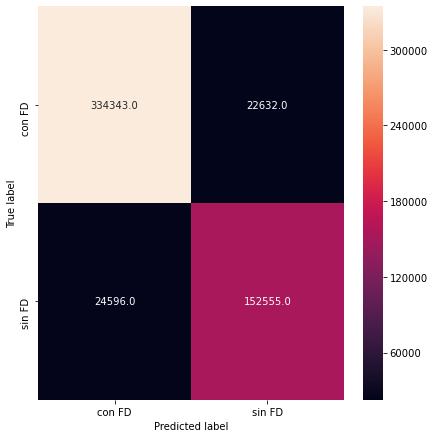

In [31]:
y_pred_thirdnnmodel = thirdnnmodel.predict_classes(val_features)
plot_confussion_matrix(y_true = val_labels, y_pred = y_pred_thirdnnmodel, classes = classes, size = 6)

In [32]:
conf_mat_thirdnnmodel = confusion_matrix(y_true=val_labels, y_pred=y_pred_thirdnnmodel)
# calculamos las diferentes métricas a partir de la matriz de confusión
total1_thirdnnmodel=sum(sum(conf_mat_thirdnnmodel))
accuracy1_thirdnnmodel=(conf_mat_thirdnnmodel[0,0]+conf_mat_thirdnnmodel[1,1])/total1_thirdnnmodel
print ('Accuracy : ', accuracy1_thirdnnmodel)
sensitivity1_thirdnnmodel = conf_mat_thirdnnmodel[0,0]/(conf_mat_thirdnnmodel[0,0]+conf_mat_thirdnnmodel[0,1])
print('Sensitivity : ', sensitivity1_thirdnnmodel )
specificity1_thirdnnmodel = conf_mat_thirdnnmodel[1,1]/(conf_mat_thirdnnmodel[1,0]+conf_mat_thirdnnmodel[1,1])
print('Specificity : ', specificity1_thirdnnmodel)
kappa_thirdnnmodel = cohen_kappa_score(y_pred_thirdnnmodel,val_labels)
print('Kappa : ', kappa_thirdnnmodel)

Accuracy :  0.9115789158363382
Sensitivity :  0.9366006022830731
Specificity :  0.8611579951566742
Kappa :  0.799992497012188


Los resultados de las dos primeras arquitecturas arrojar niveles similares. En cambio, en la tercera estructura se modificó el modelo de optimización, pasando de RMSprop a SGD, y los resultados en la métrica principal (accuracy) fueron inferiores, teniendose que aumentar el learning rate para subir la precisión del modelo. A continuación realizamos un hyperparameter tunning (escogiendo siempre el RMSprop) para poder seleccionar los parametros más adecuados (aunque probablemente la diferencia entre los mejores y peores parametros no ofrezcan grandes diferencias en los niveles de precisión).

### Hyperparameter tuning<a name="hpt"></a> 
[Volver al índice](#indice)

Aunque con las 3 estructuras anteriores nos hicimos una idea de los principales resultados (la precisión no varía mucho en función de las capas, no hace falta incorporar un número de epocas elevado, etc.), en este apartado damos un mayor felxibilidad al modelo y escogemos aquella arquitectura que nos permite obtener la máxima precisión. Además de los parámetros evaluados anteriormente se incluye un batch size diferente. 

Proposed 80 models
dense_layers :1
RMS :0.01
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_30 (Dense)             (None, 2)                 40        
Total params: 420
Trainable params: 420
Non-trainable params: 0
_________________________________________________________________
None


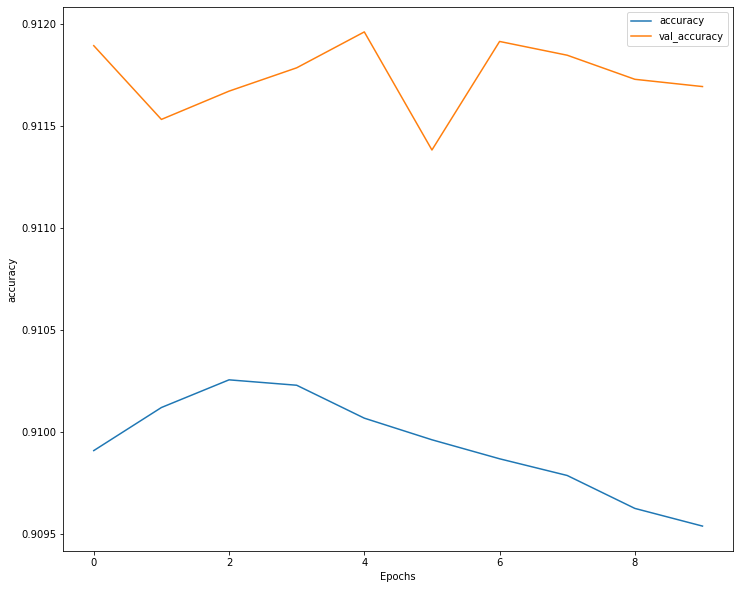

dense_layers :1
RMS :0.01
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_32 (Dense)             (None, 2)                 40        
Total params: 420
Trainable params: 420
Non-trainable params: 0
_________________________________________________________________
None


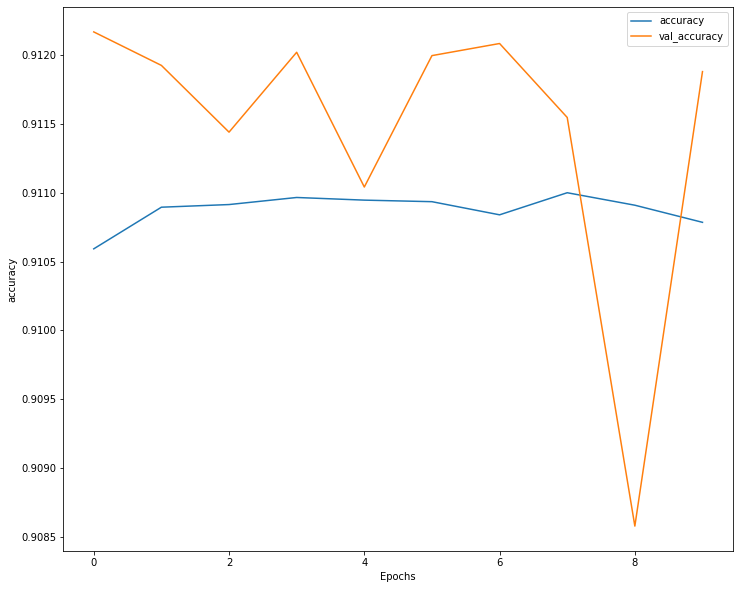

dense_layers :1
RMS :0.01
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_34 (Dense)             (None, 2)                 40        
Total params: 420
Trainable params: 420
Non-trainable params: 0
_________________________________________________________________
None


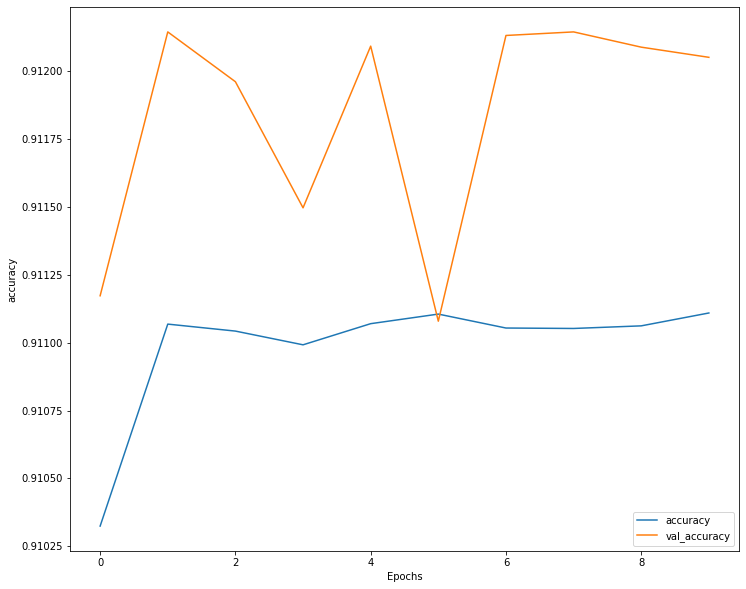

dense_layers :1
RMS :0.01
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_36 (Dense)             (None, 2)                 40        
Total params: 420
Trainable params: 420
Non-trainable params: 0
_________________________________________________________________
None


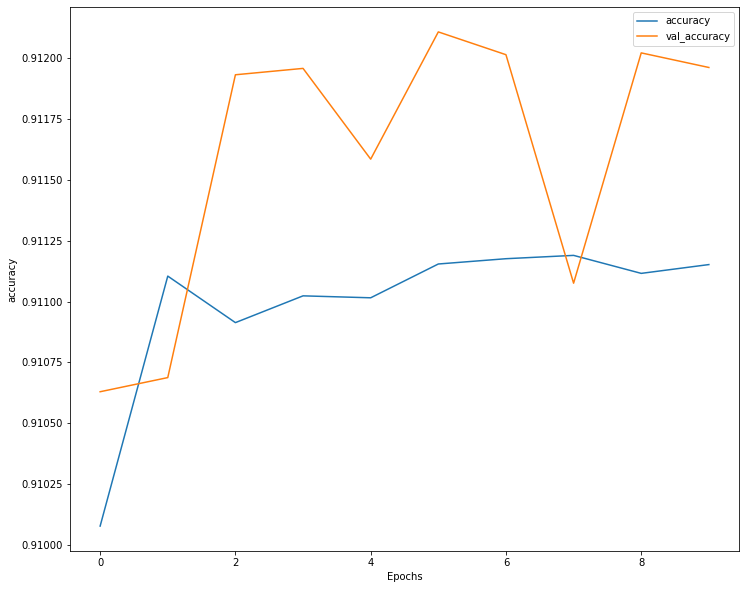

dense_layers :1
RMS :0.1
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_38 (Dense)             (None, 2)                 40        
Total params: 420
Trainable params: 420
Non-trainable params: 0
_________________________________________________________________
None


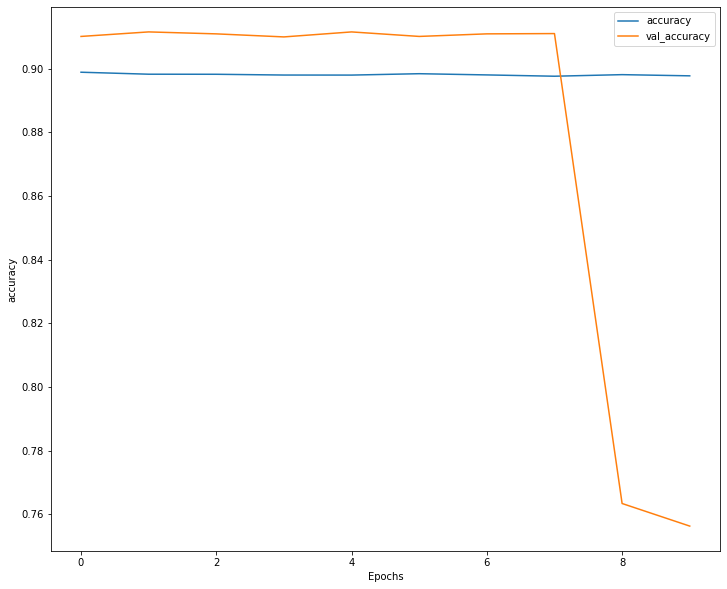

dense_layers :1
RMS :0.1
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_40 (Dense)             (None, 2)                 40        
Total params: 420
Trainable params: 420
Non-trainable params: 0
_________________________________________________________________
None


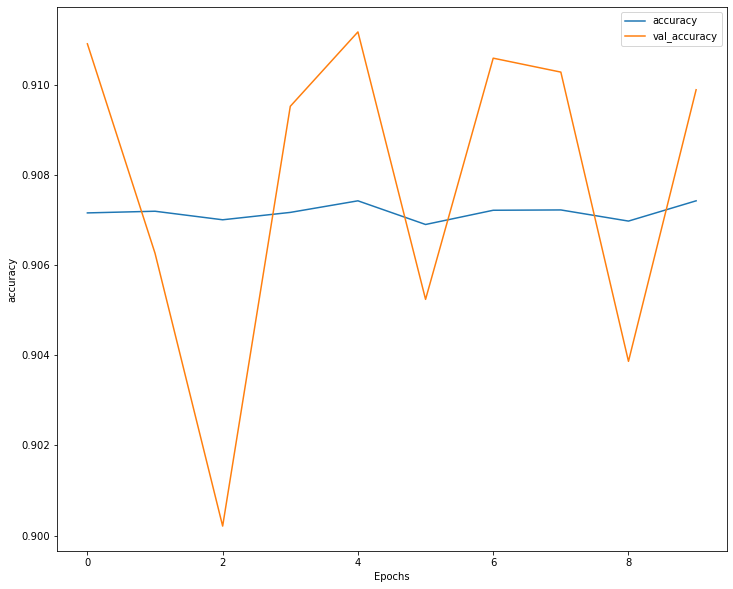

dense_layers :1
RMS :0.1
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_42 (Dense)             (None, 2)                 40        
Total params: 420
Trainable params: 420
Non-trainable params: 0
_________________________________________________________________
None


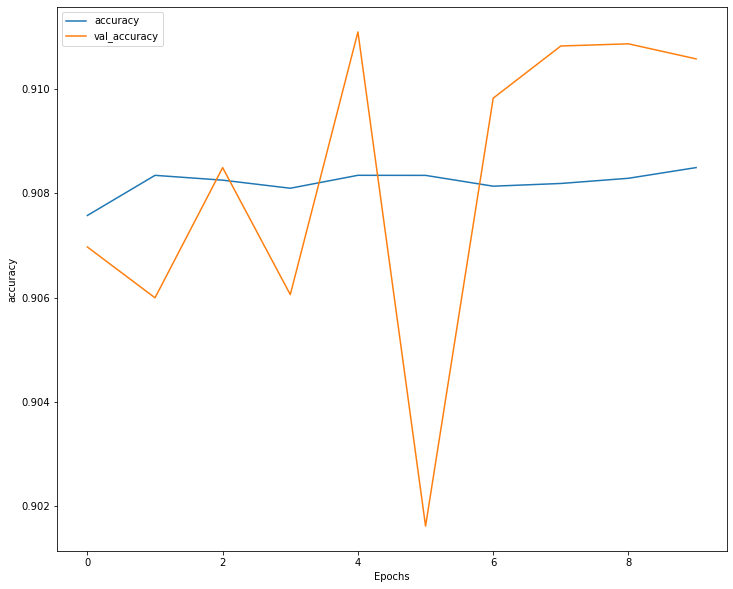

dense_layers :1
RMS :0.1
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_43 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_44 (Dense)             (None, 2)                 40        
Total params: 420
Trainable params: 420
Non-trainable params: 0
_________________________________________________________________
None


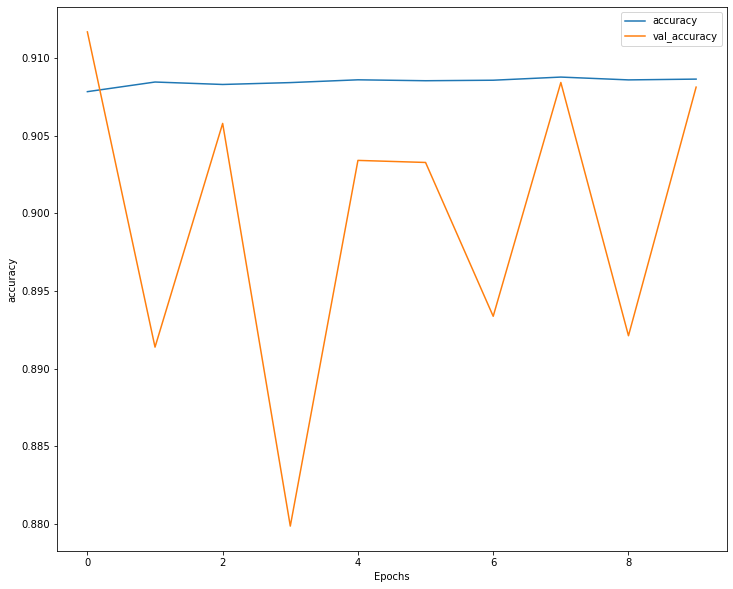

dense_layers :2
RMS :0.01
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_46 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_47 (Dense)             (None, 2)                 40        
Total params: 800
Trainable params: 800
Non-trainable params: 0
_________________________________________________________________
None


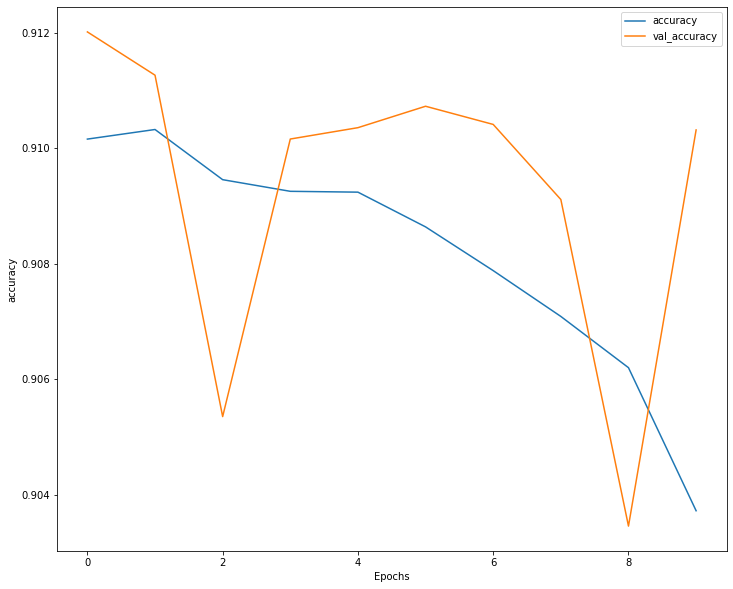

dense_layers :2
RMS :0.01
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_49 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_50 (Dense)             (None, 2)                 40        
Total params: 800
Trainable params: 800
Non-trainable params: 0
_________________________________________________________________
None


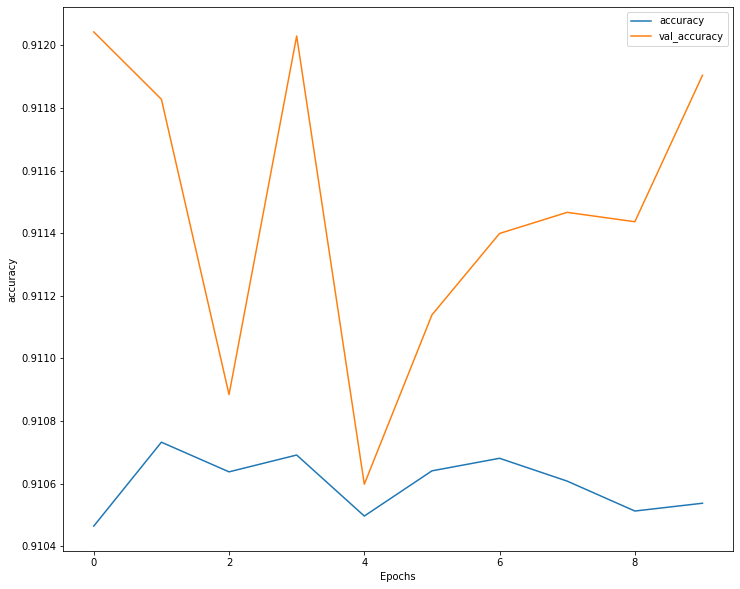

dense_layers :2
RMS :0.01
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_51 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_52 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_53 (Dense)             (None, 2)                 40        
Total params: 800
Trainable params: 800
Non-trainable params: 0
_________________________________________________________________
None


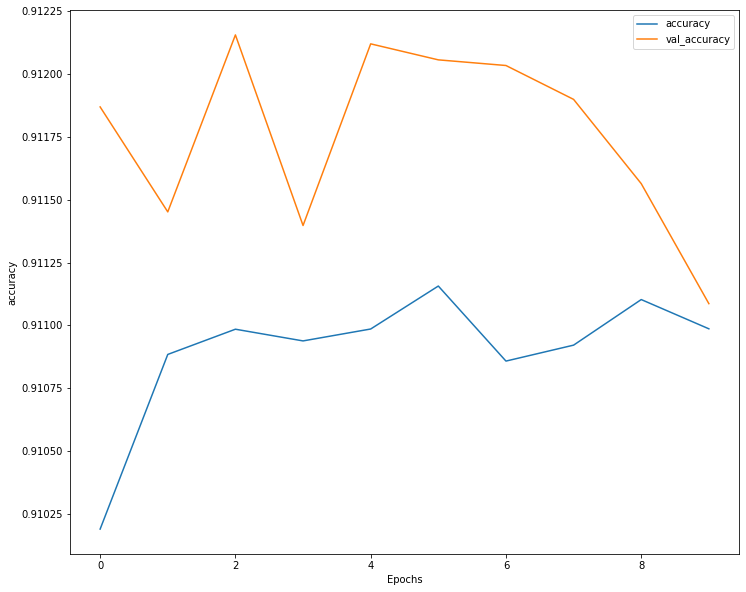

dense_layers :2
RMS :0.01
Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_55 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_56 (Dense)             (None, 2)                 40        
Total params: 800
Trainable params: 800
Non-trainable params: 0
_________________________________________________________________
None


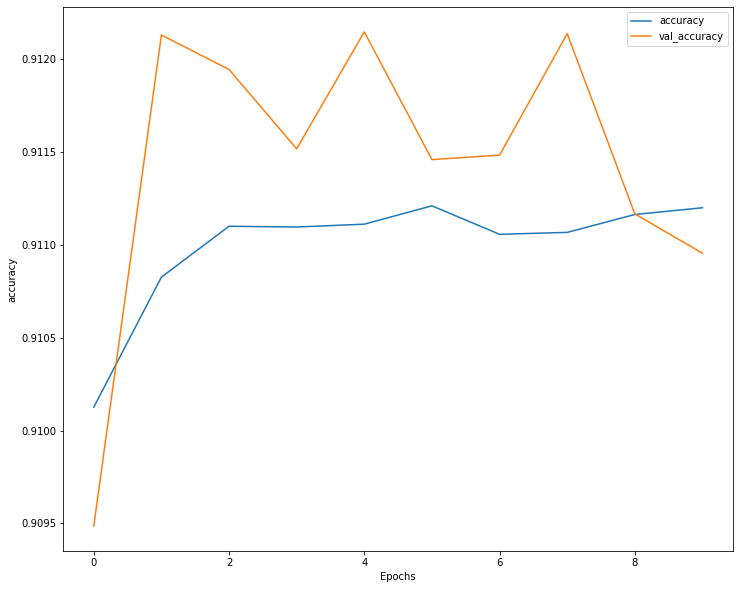

dense_layers :2
RMS :0.1
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_57 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_58 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_59 (Dense)             (None, 2)                 40        
Total params: 800
Trainable params: 800
Non-trainable params: 0
_________________________________________________________________
None


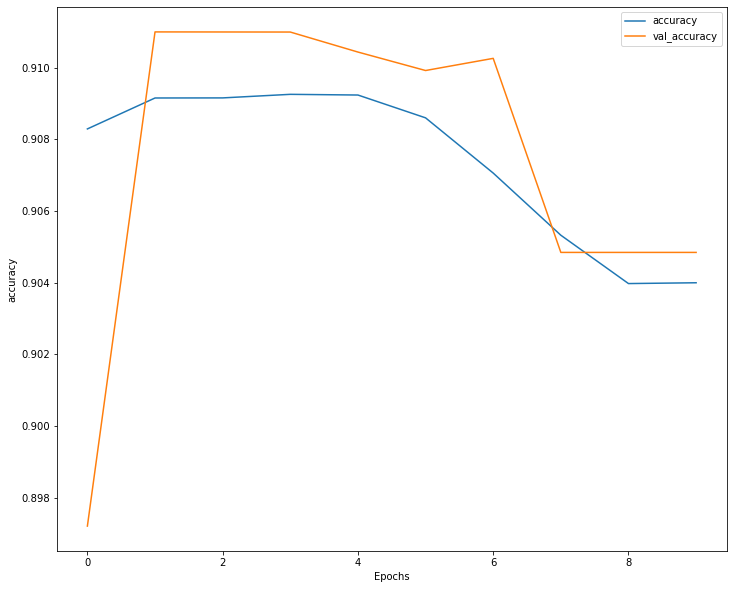

dense_layers :2
RMS :0.1
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_60 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_61 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_62 (Dense)             (None, 2)                 40        
Total params: 800
Trainable params: 800
Non-trainable params: 0
_________________________________________________________________
None


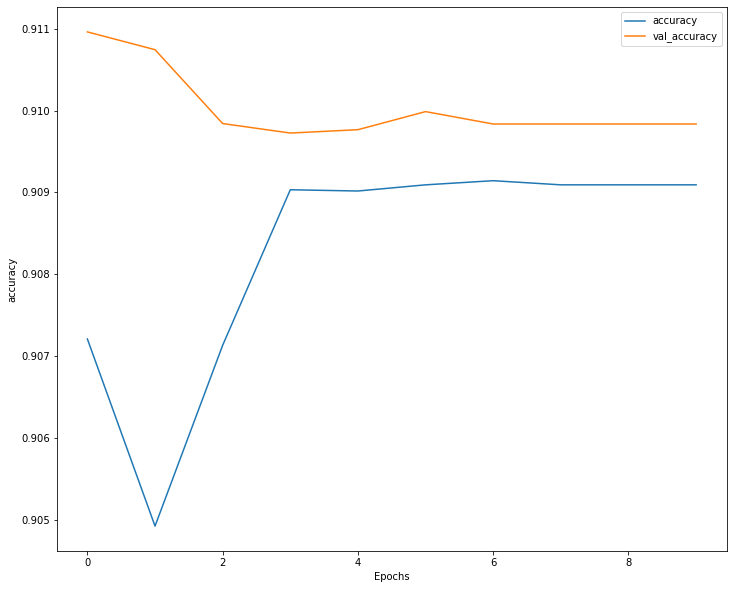

dense_layers :2
RMS :0.1
Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_63 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_64 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_65 (Dense)             (None, 2)                 40        
Total params: 800
Trainable params: 800
Non-trainable params: 0
_________________________________________________________________
None


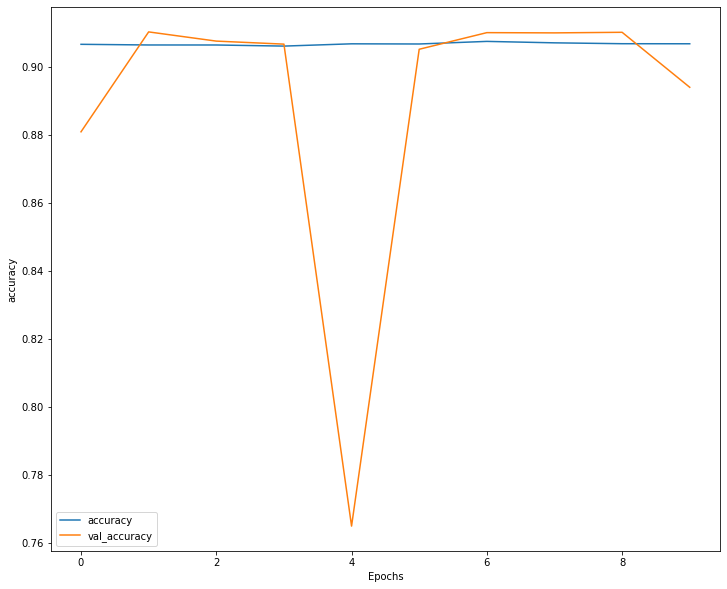

dense_layers :2
RMS :0.1
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_66 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_67 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_68 (Dense)             (None, 2)                 40        
Total params: 800
Trainable params: 800
Non-trainable params: 0
_________________________________________________________________
None


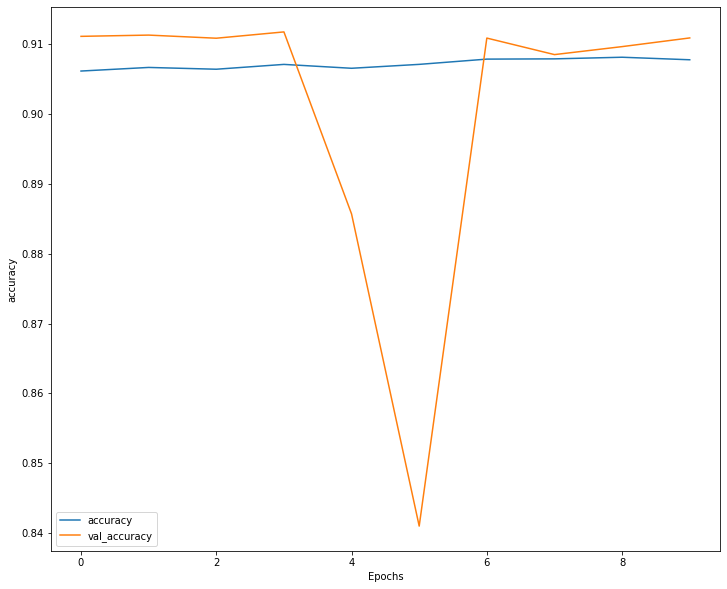

dense_layers :3
RMS :0.01
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_69 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_70 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_71 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_72 (Dense)             (None, 2)                 40        
Total params: 1,180
Trainable params: 1,180
Non-trainable params: 0
_________________________________________________________________
None


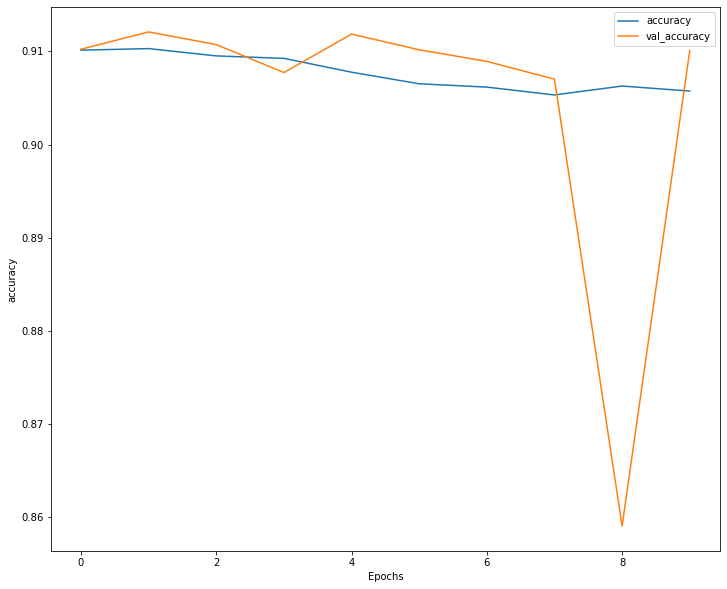

dense_layers :3
RMS :0.01
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_73 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_74 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_75 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_76 (Dense)             (None, 2)                 40        
Total params: 1,180
Trainable params: 1,180
Non-trainable params: 0
_________________________________________________________________
None


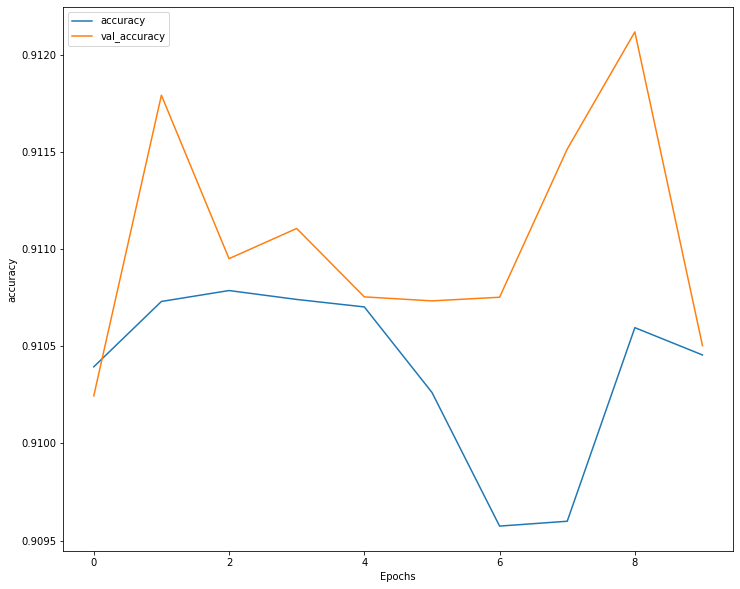

dense_layers :3
RMS :0.01
Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_77 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_78 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_79 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_80 (Dense)             (None, 2)                 40        
Total params: 1,180
Trainable params: 1,180
Non-trainable params: 0
_________________________________________________________________
None


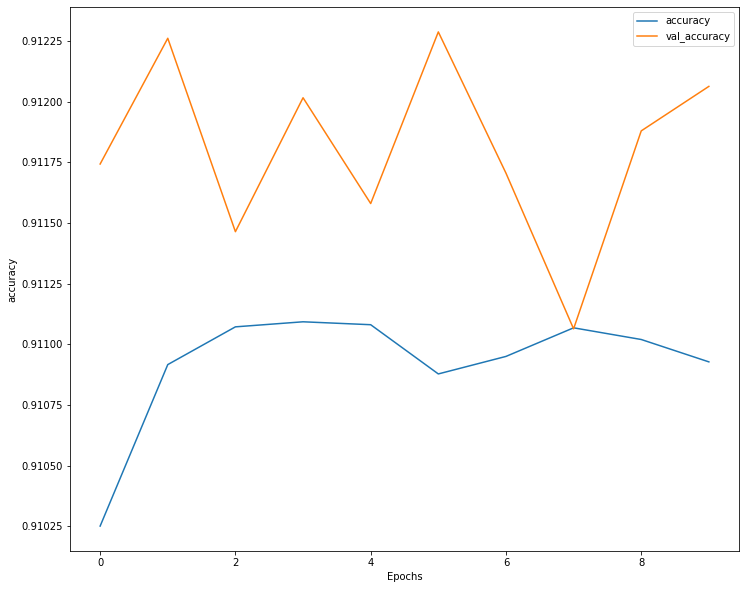

dense_layers :3
RMS :0.01
Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_81 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_82 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_83 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_84 (Dense)             (None, 2)                 40        
Total params: 1,180
Trainable params: 1,180
Non-trainable params: 0
_________________________________________________________________
None


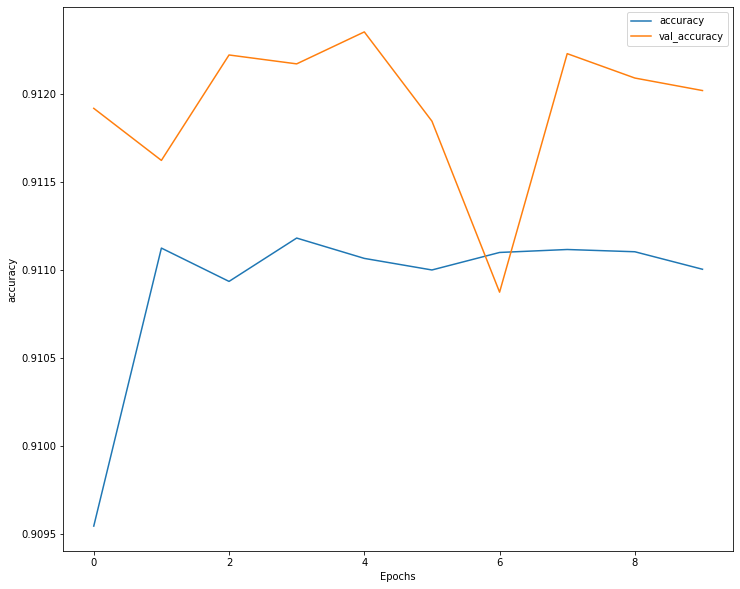

dense_layers :3
RMS :0.1
Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_85 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_86 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_87 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_88 (Dense)             (None, 2)                 40        
Total params: 1,180
Trainable params: 1,180
Non-trainable params: 0
_________________________________________________________________
None


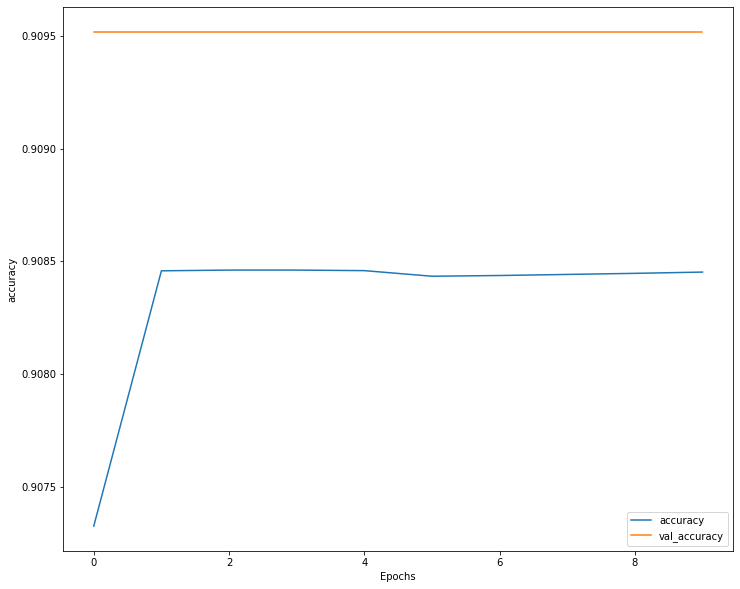

dense_layers :3
RMS :0.1
Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_89 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_90 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_91 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_92 (Dense)             (None, 2)                 40        
Total params: 1,180
Trainable params: 1,180
Non-trainable params: 0
_________________________________________________________________
None


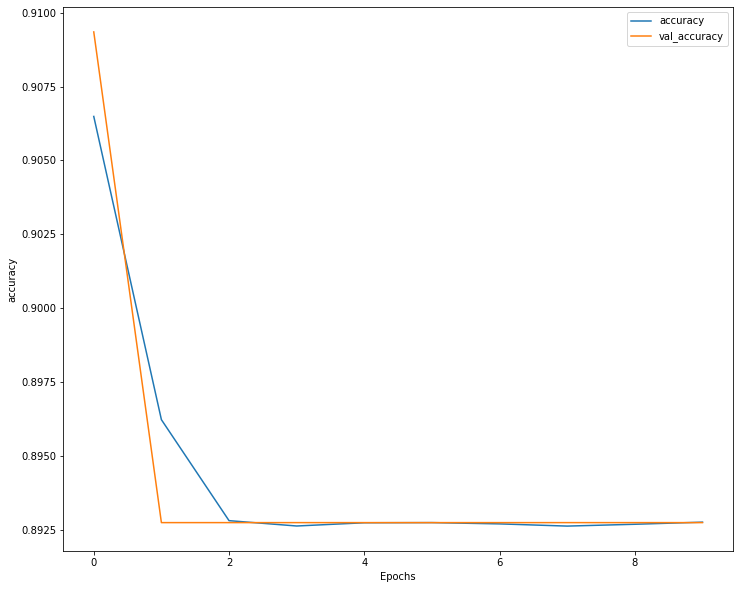

dense_layers :3
RMS :0.1
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_93 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_94 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_95 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_96 (Dense)             (None, 2)                 40        
Total params: 1,180
Trainable params: 1,180
Non-trainable params: 0
_________________________________________________________________
None


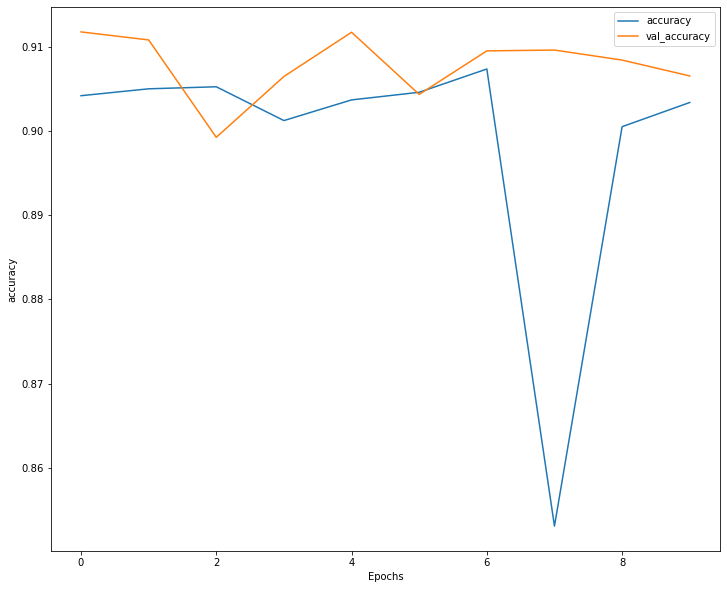

dense_layers :3
RMS :0.1
Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_97 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_98 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_99 (Dense)             (None, 19)                380       
_________________________________________________________________
dense_100 (Dense)            (None, 2)                 40        
Total params: 1,180
Trainable params: 1,180
Non-trainable params: 0
_________________________________________________________________
None


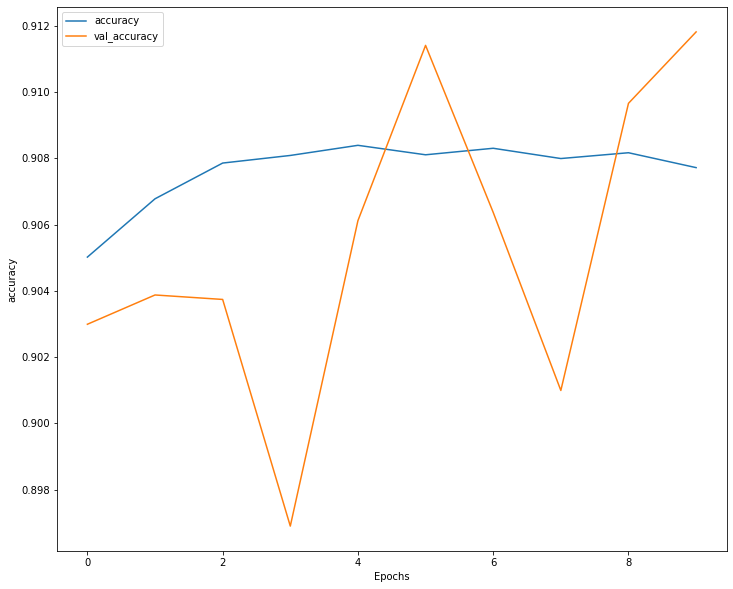

dense_layers :4
RMS :0.01
Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_101 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_102 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_103 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_104 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_105 (Dense)            (None, 2)                 40        
Total params: 1,560
Trainable params: 1,560
Non-trainable params: 0
_________________________________________________________________
None


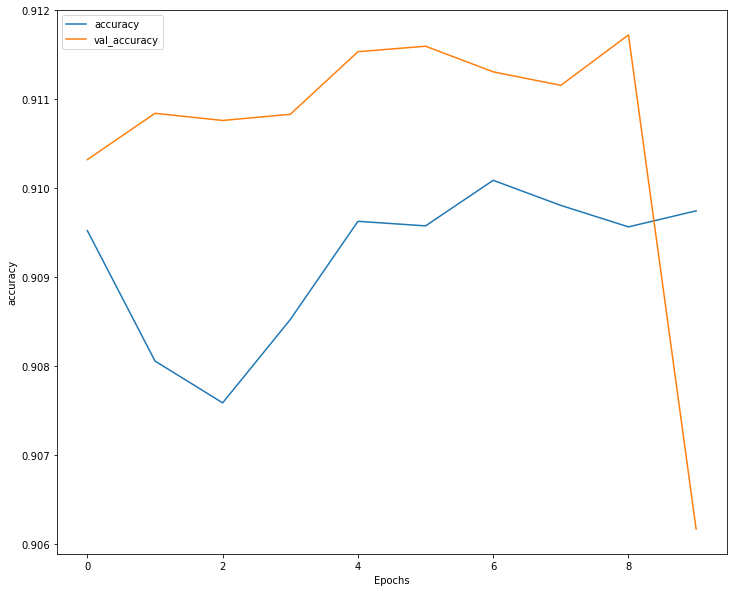

dense_layers :4
RMS :0.01
Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_106 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_107 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_108 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_109 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_110 (Dense)            (None, 2)                 40        
Total params: 1,560
Trainable params: 1,560
Non-trainable params: 0
_________________________________________________________________
None


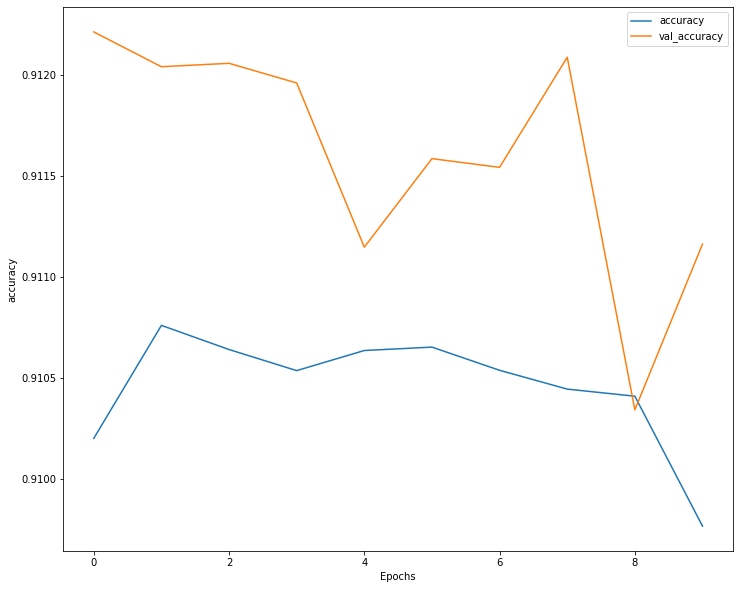

dense_layers :4
RMS :0.01
Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_111 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_112 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_113 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_114 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_115 (Dense)            (None, 2)                 40        
Total params: 1,560
Trainable params: 1,560
Non-trainable params: 0
_________________________________________________________________
None


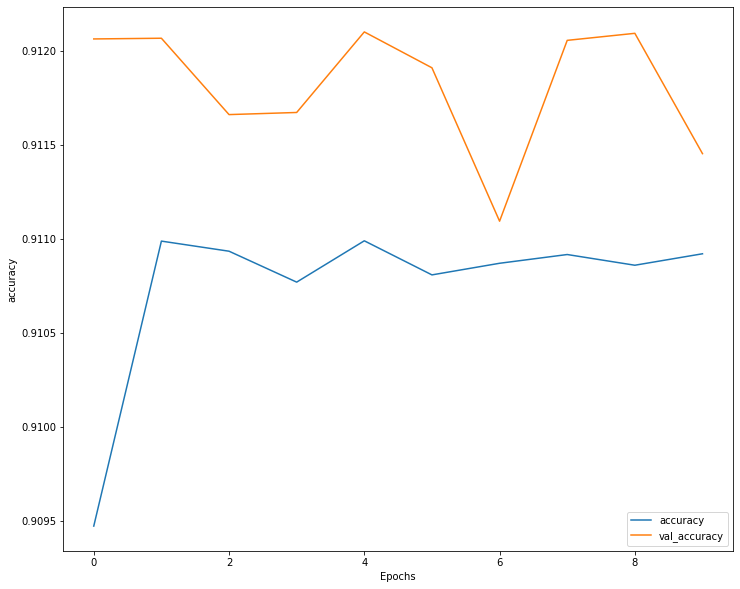

dense_layers :4
RMS :0.01
Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_116 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_117 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_118 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_119 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_120 (Dense)            (None, 2)                 40        
Total params: 1,560
Trainable params: 1,560
Non-trainable params: 0
_________________________________________________________________
None


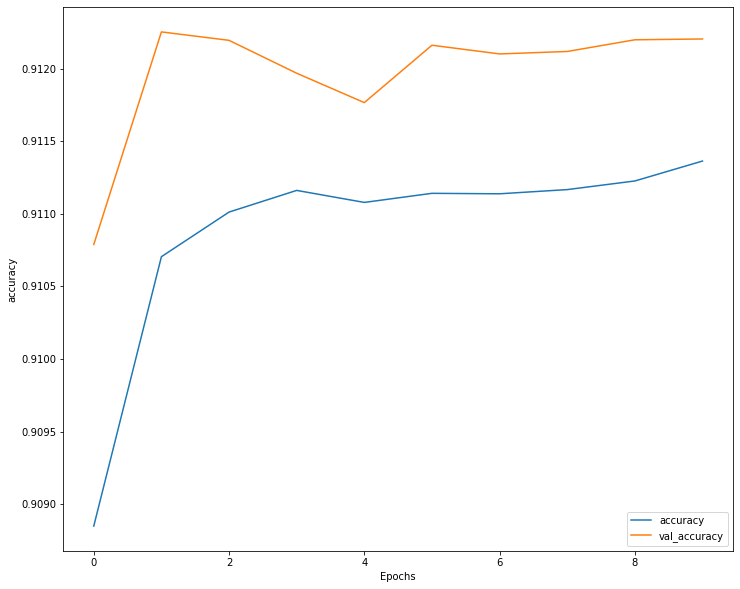

dense_layers :4
RMS :0.1
Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_121 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_122 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_123 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_124 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_125 (Dense)            (None, 2)                 40        
Total params: 1,560
Trainable params: 1,560
Non-trainable params: 0
_________________________________________________________________
None


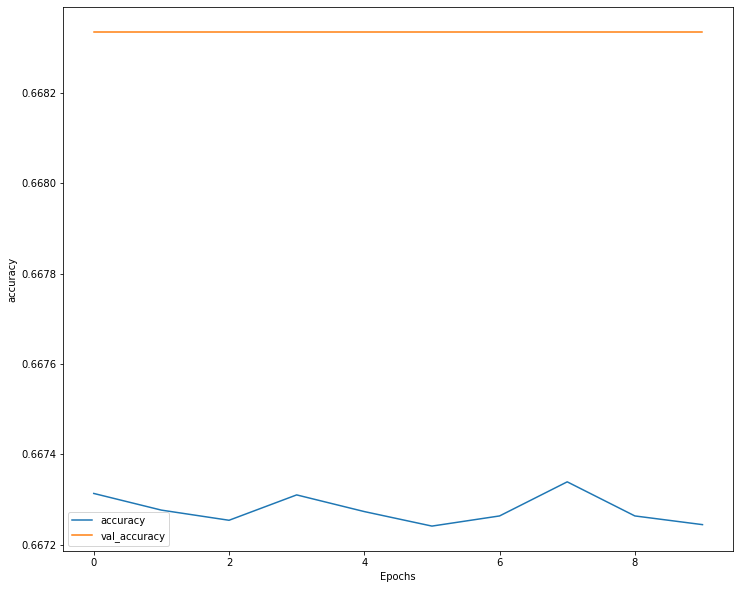

dense_layers :4
RMS :0.1
Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_126 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_127 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_128 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_129 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_130 (Dense)            (None, 2)                 40        
Total params: 1,560
Trainable params: 1,560
Non-trainable params: 0
_________________________________________________________________
None


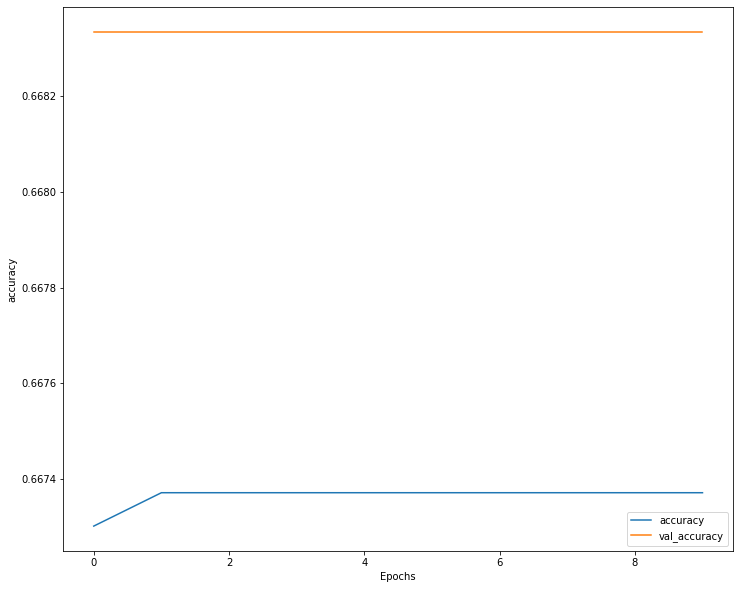

dense_layers :4
RMS :0.1
Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_131 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_132 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_133 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_134 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_135 (Dense)            (None, 2)                 40        
Total params: 1,560
Trainable params: 1,560
Non-trainable params: 0
_________________________________________________________________
None


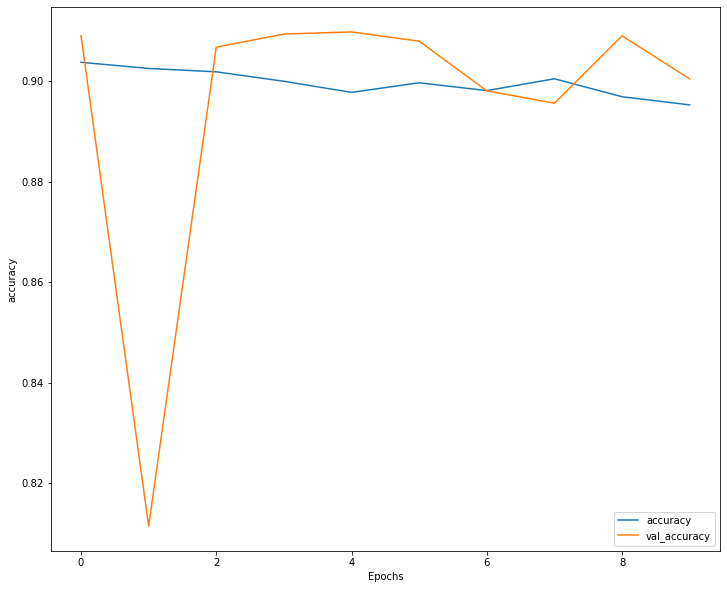

dense_layers :4
RMS :0.1
Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_136 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_137 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_138 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_139 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_140 (Dense)            (None, 2)                 40        
Total params: 1,560
Trainable params: 1,560
Non-trainable params: 0
_________________________________________________________________
None


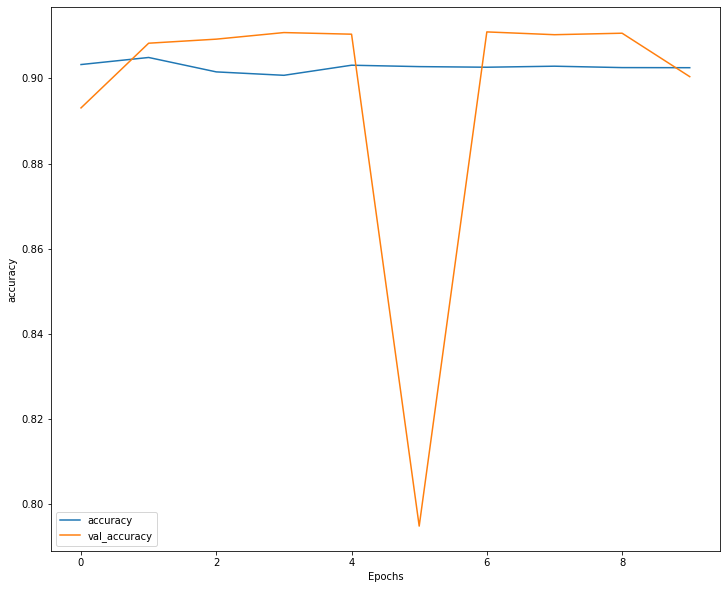

dense_layers :5
RMS :0.01
Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_141 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_142 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_143 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_144 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_145 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_146 (Dense)            (None, 2)                 40        
Total params: 1,940
Trainable params: 1,940
Non-trainable params: 0
_________________________

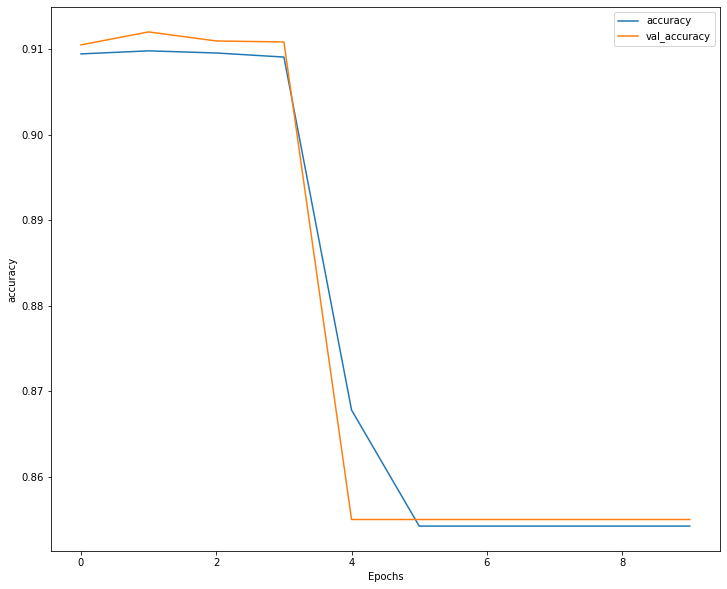

dense_layers :5
RMS :0.01
Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_147 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_148 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_149 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_150 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_151 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_152 (Dense)            (None, 2)                 40        
Total params: 1,940
Trainable params: 1,940
Non-trainable params: 0
_________________________

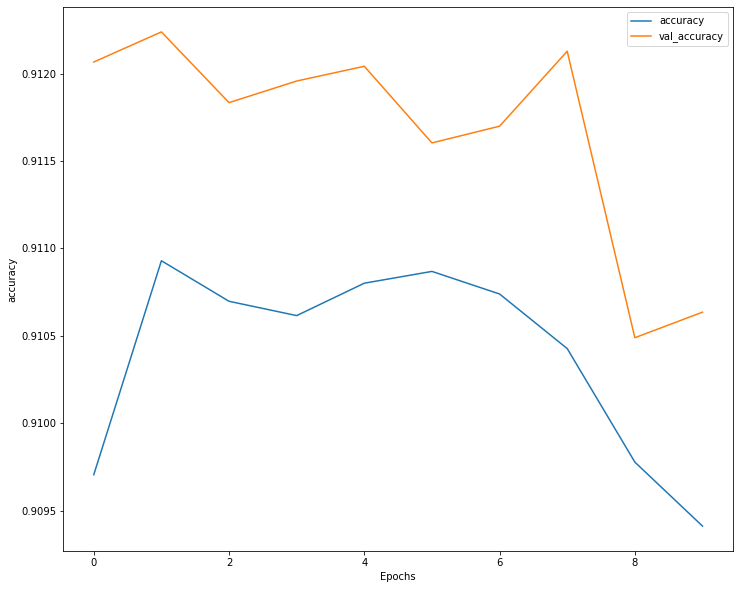

dense_layers :5
RMS :0.01
Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_153 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_154 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_155 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_156 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_157 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_158 (Dense)            (None, 2)                 40        
Total params: 1,940
Trainable params: 1,940
Non-trainable params: 0
_________________________

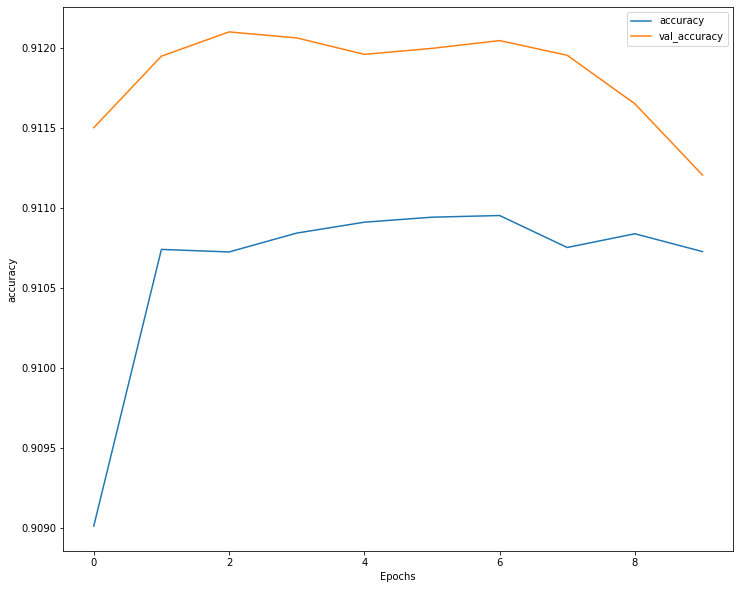

dense_layers :5
RMS :0.01
Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_159 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_160 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_161 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_162 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_163 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_164 (Dense)            (None, 2)                 40        
Total params: 1,940
Trainable params: 1,940
Non-trainable params: 0
_________________________

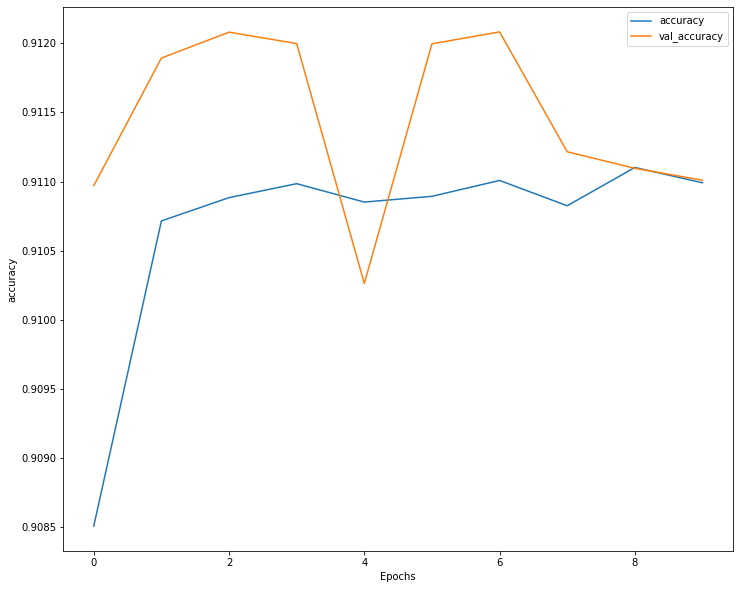

dense_layers :5
RMS :0.1
Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_165 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_166 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_167 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_168 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_169 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_170 (Dense)            (None, 2)                 40        
Total params: 1,940
Trainable params: 1,940
Non-trainable params: 0
__________________________

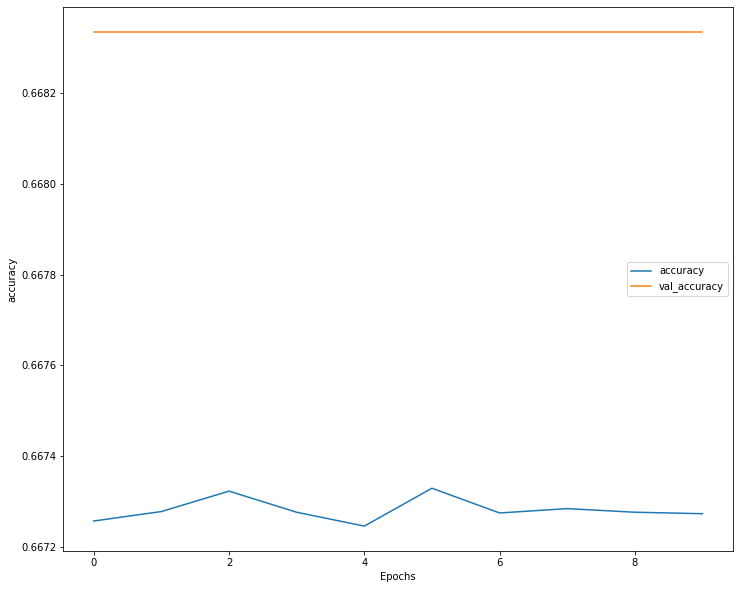

dense_layers :5
RMS :0.1
Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_171 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_172 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_173 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_174 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_175 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_176 (Dense)            (None, 2)                 40        
Total params: 1,940
Trainable params: 1,940
Non-trainable params: 0
__________________________

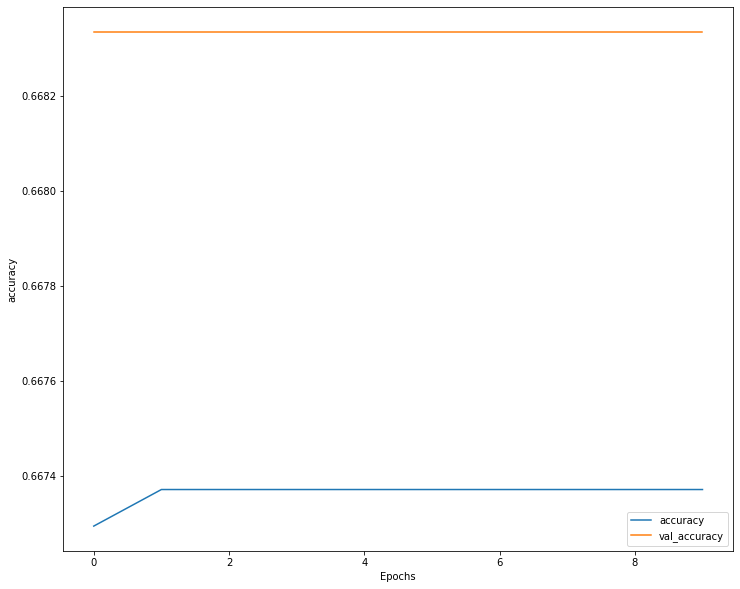

dense_layers :5
RMS :0.1
Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_177 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_178 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_179 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_180 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_181 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_182 (Dense)            (None, 2)                 40        
Total params: 1,940
Trainable params: 1,940
Non-trainable params: 0
__________________________

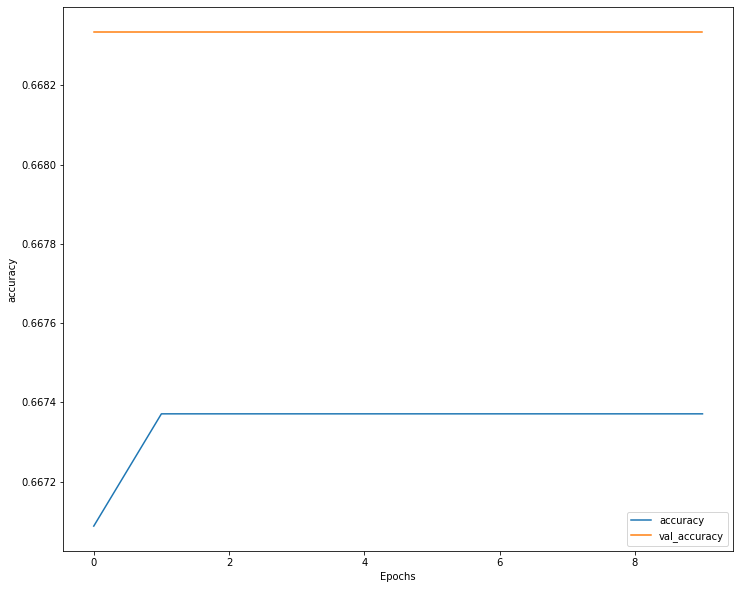

dense_layers :5
RMS :0.1
Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_183 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_184 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_185 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_186 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_187 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_188 (Dense)            (None, 2)                 40        
Total params: 1,940
Trainable params: 1,940
Non-trainable params: 0
__________________________

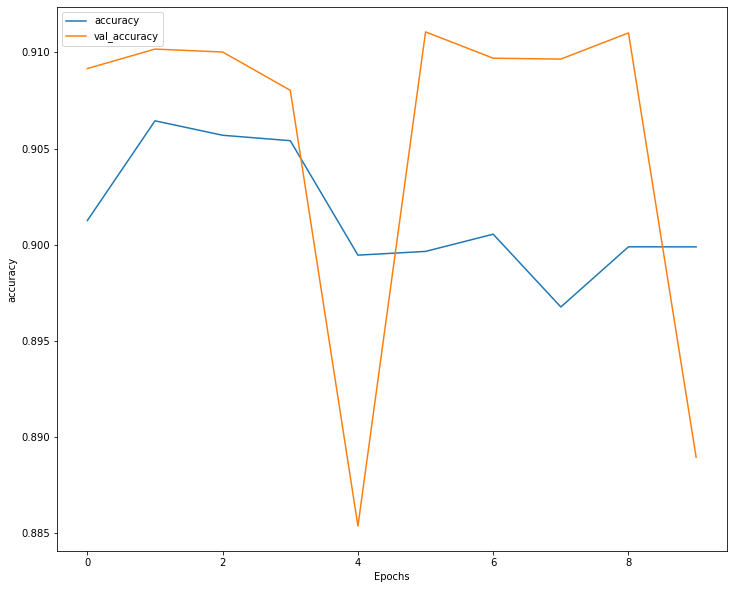

dense_layers :6
RMS :0.01
Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_189 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_190 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_191 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_192 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_193 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_194 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_195 (Dense)          

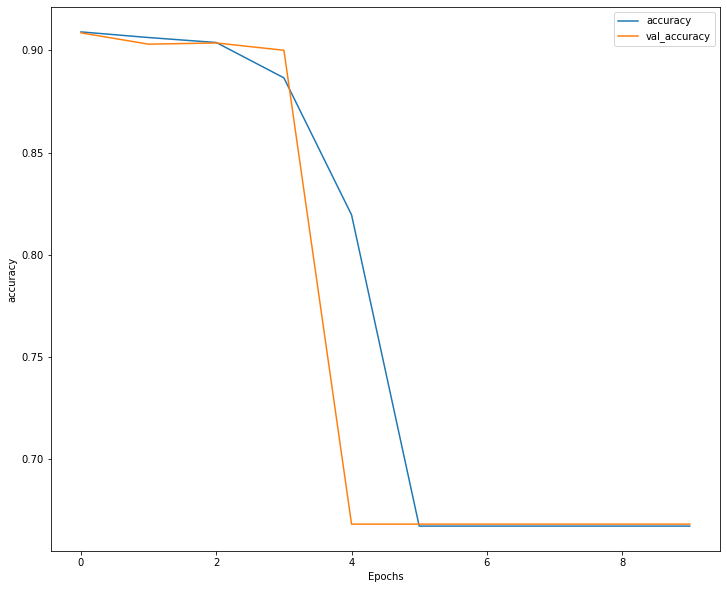

dense_layers :6
RMS :0.01
Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_196 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_197 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_198 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_199 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_200 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_201 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_202 (Dense)          

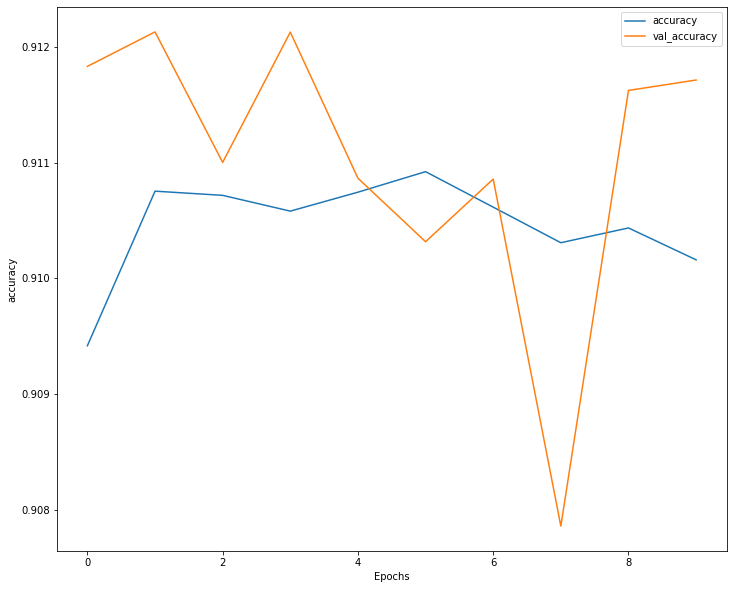

dense_layers :6
RMS :0.01
Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_203 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_204 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_205 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_206 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_207 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_208 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_209 (Dense)          

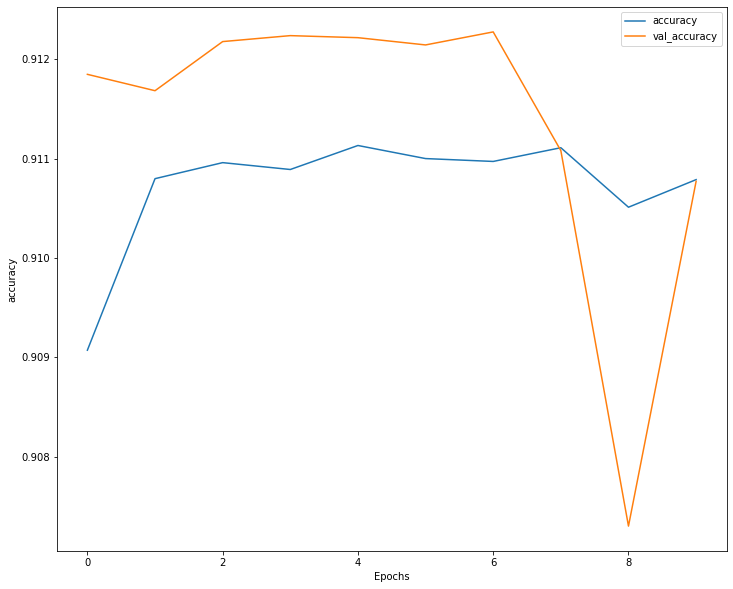

dense_layers :6
RMS :0.01
Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_210 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_211 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_212 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_213 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_214 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_215 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_216 (Dense)          

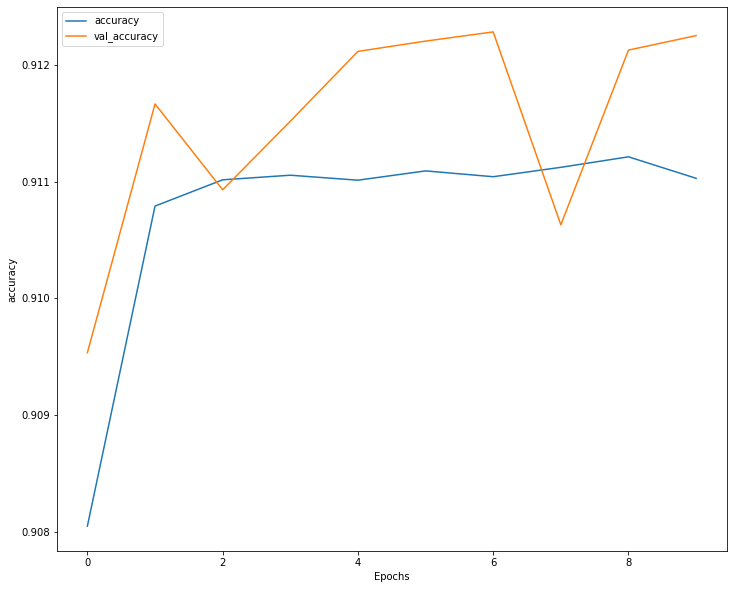

dense_layers :6
RMS :0.1
Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_217 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_218 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_219 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_220 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_221 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_222 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_223 (Dense)           

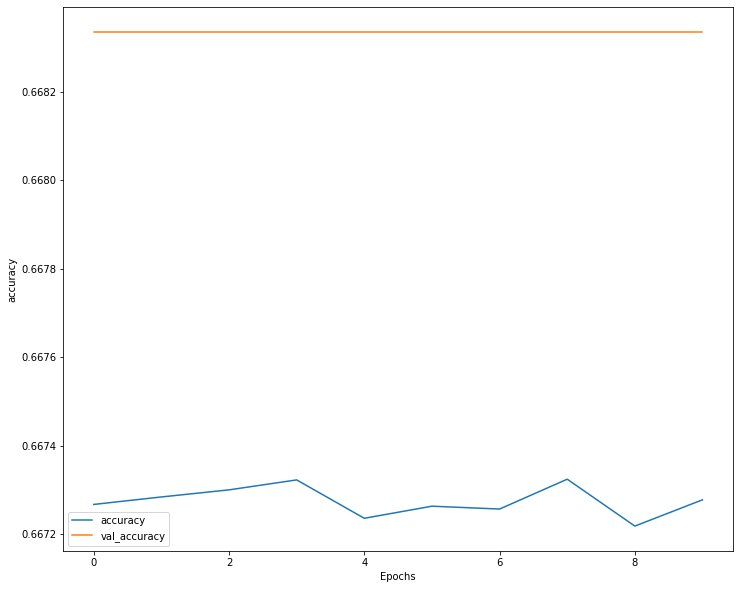

dense_layers :6
RMS :0.1
Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_224 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_225 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_226 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_227 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_228 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_229 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_230 (Dense)           

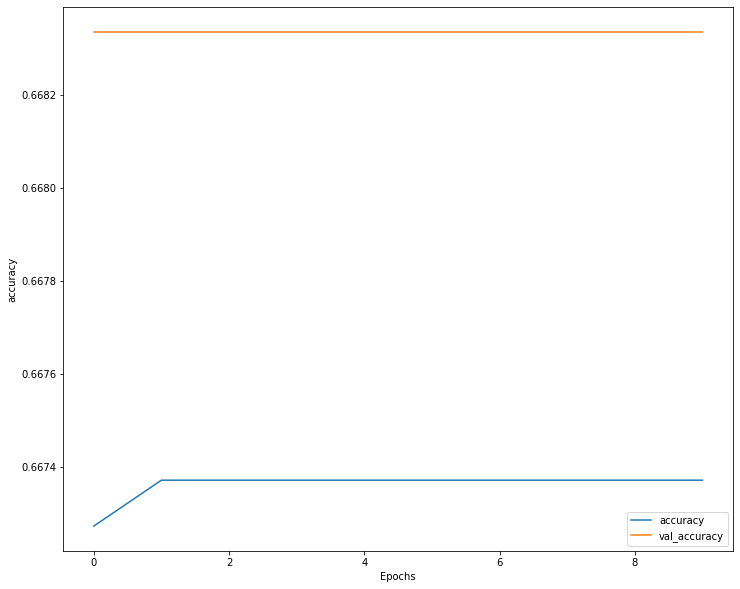

dense_layers :6
RMS :0.1
Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_231 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_232 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_233 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_234 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_235 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_236 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_237 (Dense)           

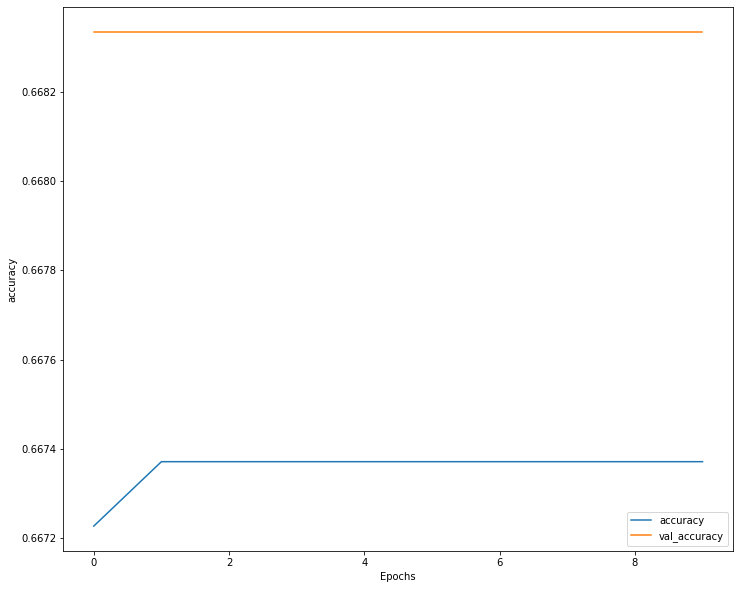

dense_layers :6
RMS :0.1
Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_238 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_239 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_240 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_241 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_242 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_243 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_244 (Dense)           

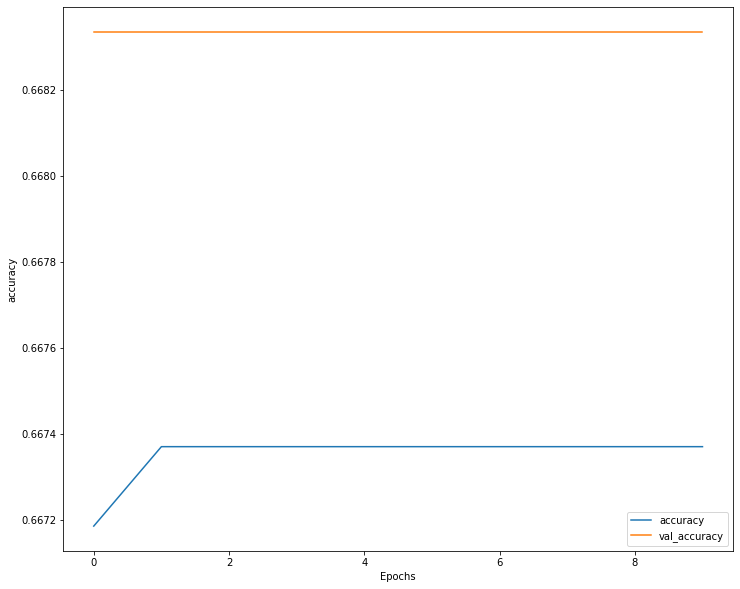

dense_layers :7
RMS :0.01
Model: "sequential_52"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_245 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_246 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_247 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_248 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_249 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_250 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_251 (Dense)          

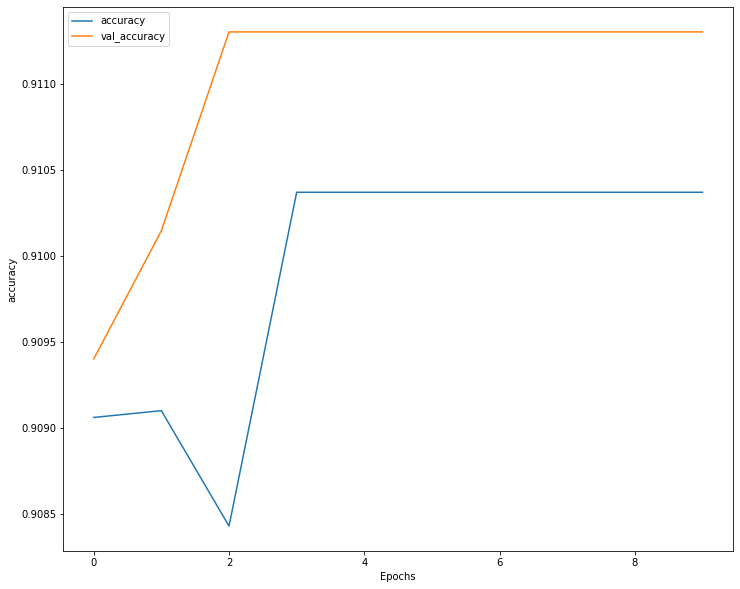

dense_layers :7
RMS :0.01
Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_253 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_254 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_255 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_256 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_257 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_258 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_259 (Dense)          

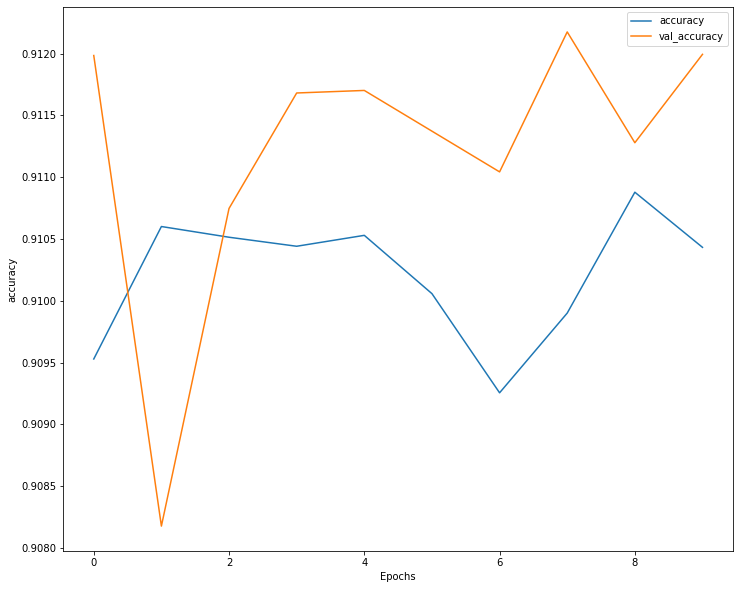

dense_layers :7
RMS :0.01
Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_261 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_262 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_263 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_264 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_265 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_266 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_267 (Dense)          

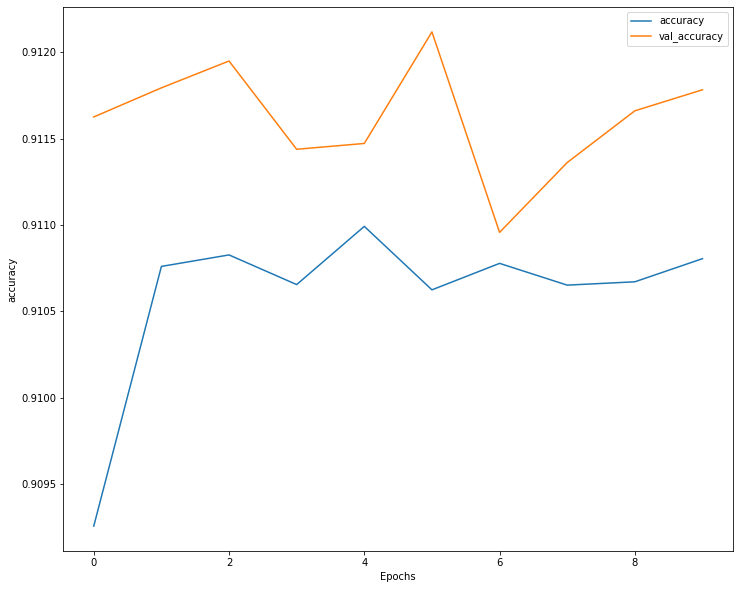

dense_layers :7
RMS :0.01
Model: "sequential_55"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_269 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_270 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_271 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_272 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_273 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_274 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_275 (Dense)          

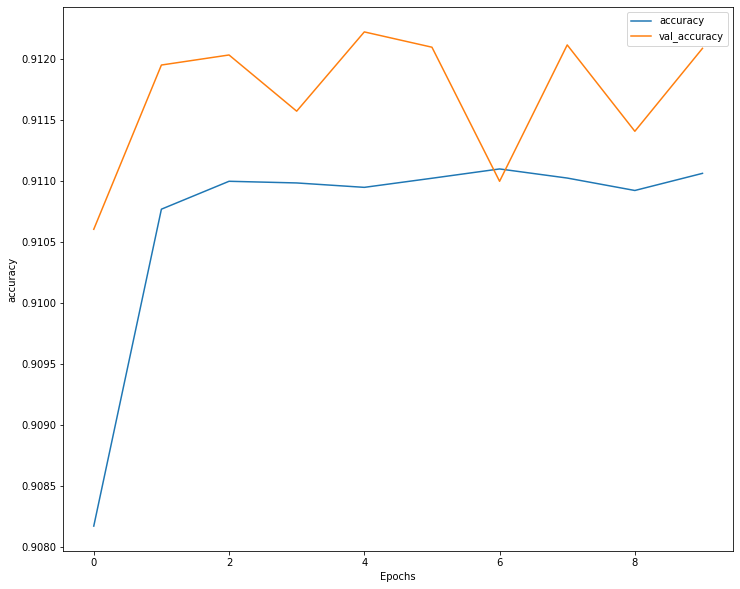

dense_layers :7
RMS :0.1
Model: "sequential_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_277 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_278 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_279 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_280 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_281 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_282 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_283 (Dense)           

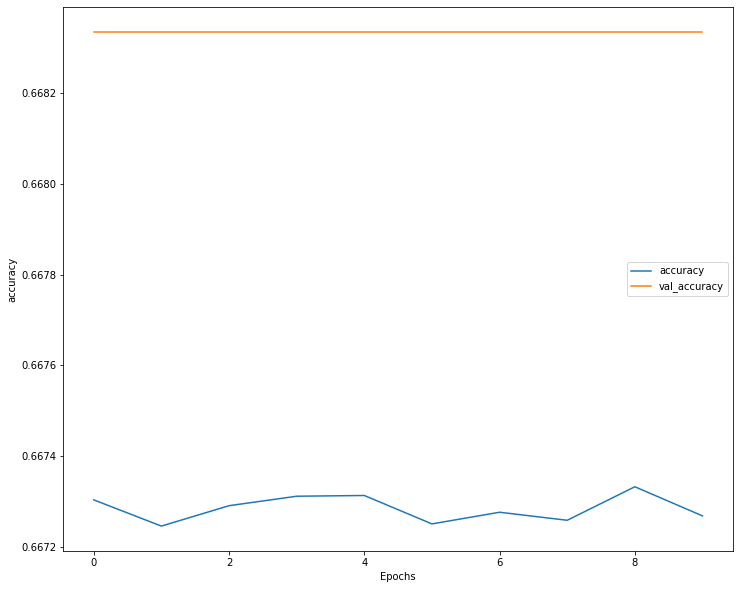

dense_layers :7
RMS :0.1
Model: "sequential_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_285 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_286 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_287 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_288 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_289 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_290 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_291 (Dense)           

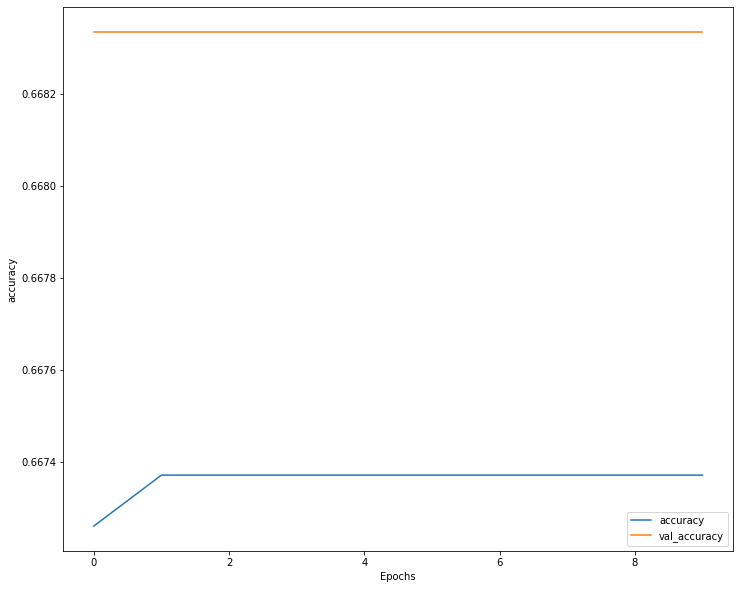

dense_layers :7
RMS :0.1
Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_293 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_294 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_295 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_296 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_297 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_298 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_299 (Dense)           

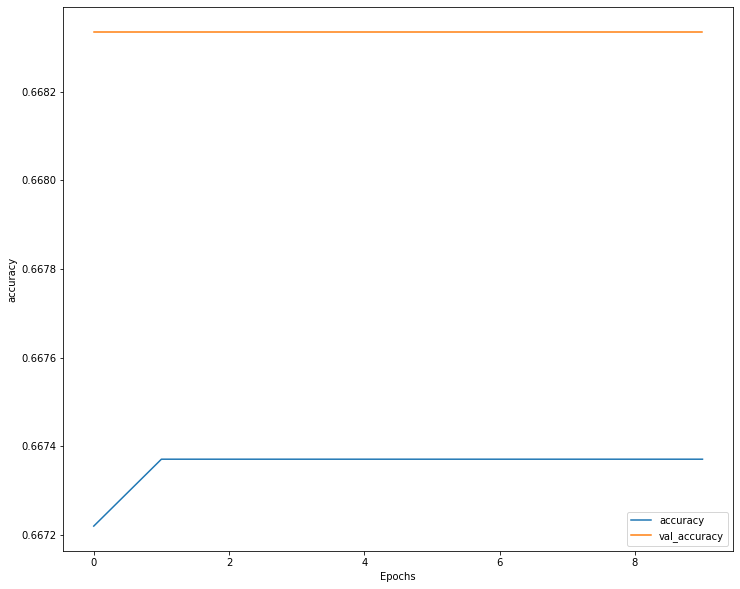

dense_layers :7
RMS :0.1
Model: "sequential_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_301 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_302 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_303 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_304 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_305 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_306 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_307 (Dense)           

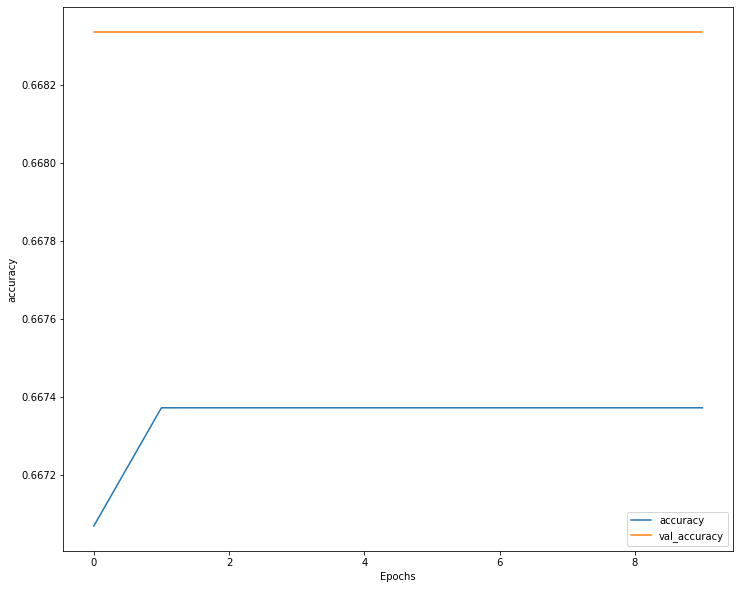

dense_layers :8
RMS :0.01
Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_309 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_310 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_311 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_312 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_313 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_314 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_315 (Dense)          

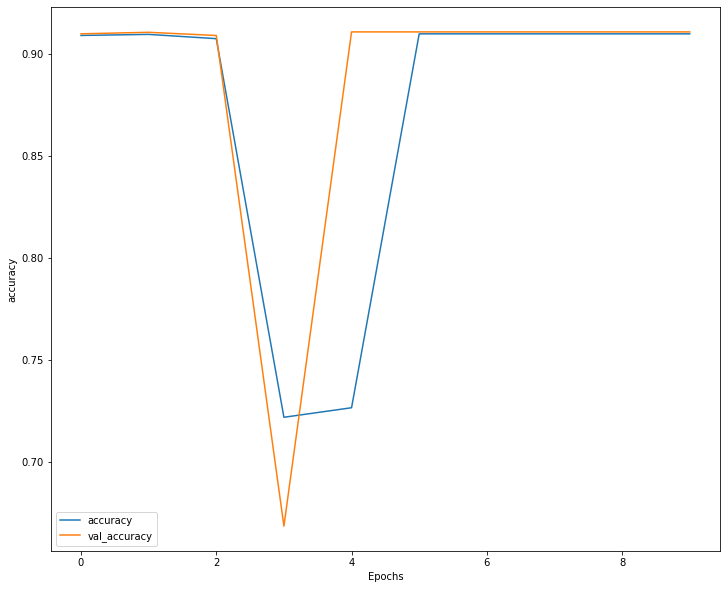

dense_layers :8
RMS :0.01
Model: "sequential_61"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_318 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_319 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_320 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_321 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_322 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_323 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_324 (Dense)          

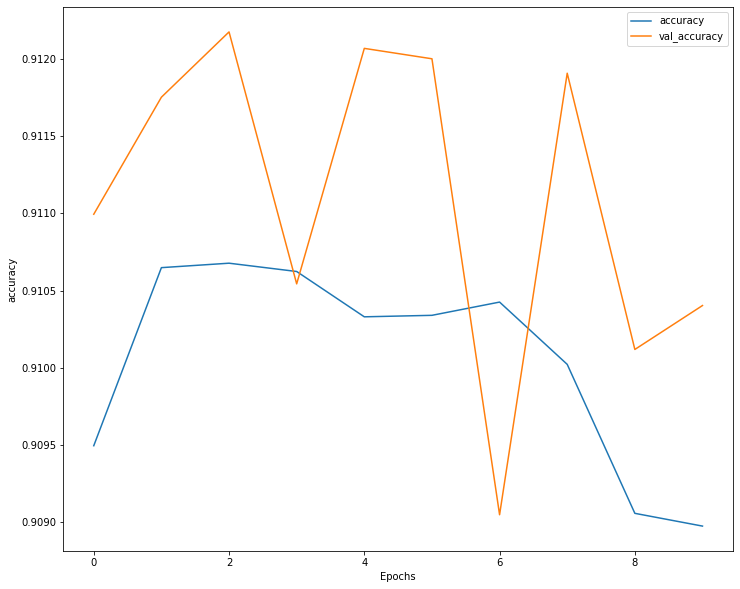

dense_layers :8
RMS :0.01
Model: "sequential_62"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_327 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_328 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_329 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_330 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_331 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_332 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_333 (Dense)          

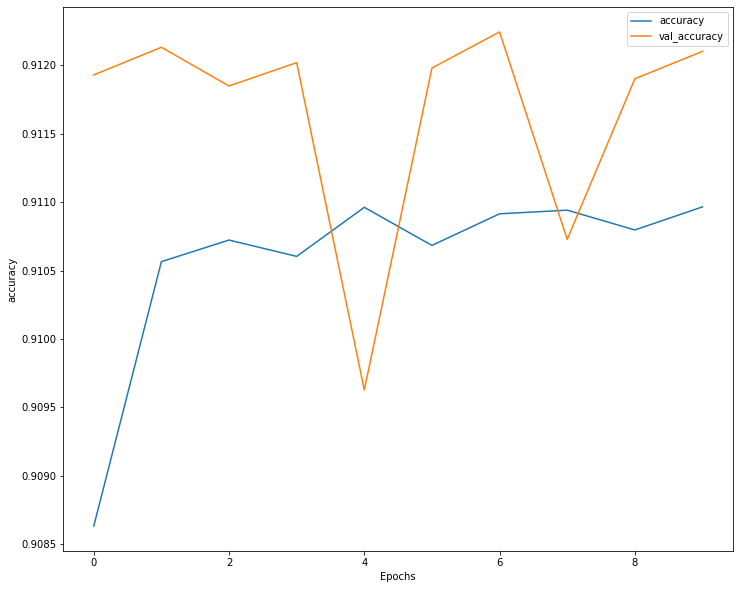

dense_layers :8
RMS :0.01
Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_336 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_337 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_338 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_339 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_340 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_341 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_342 (Dense)          

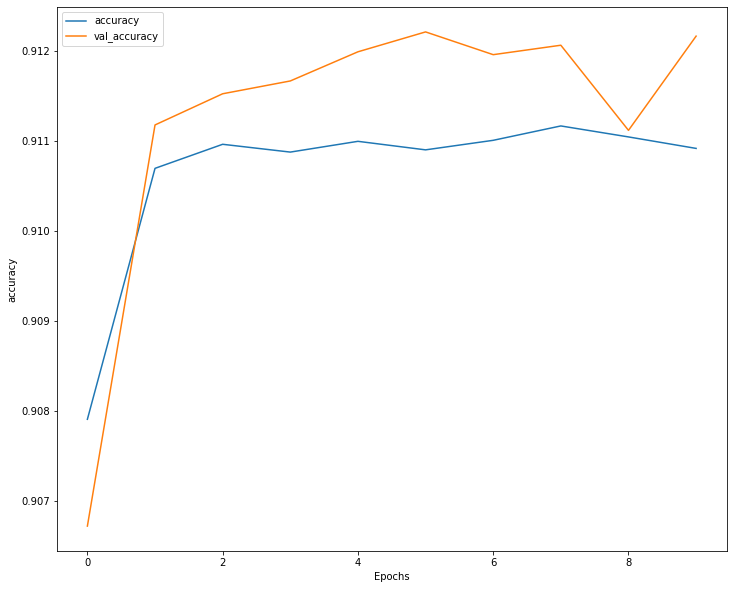

dense_layers :8
RMS :0.1
Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_345 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_346 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_347 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_348 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_349 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_350 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_351 (Dense)           

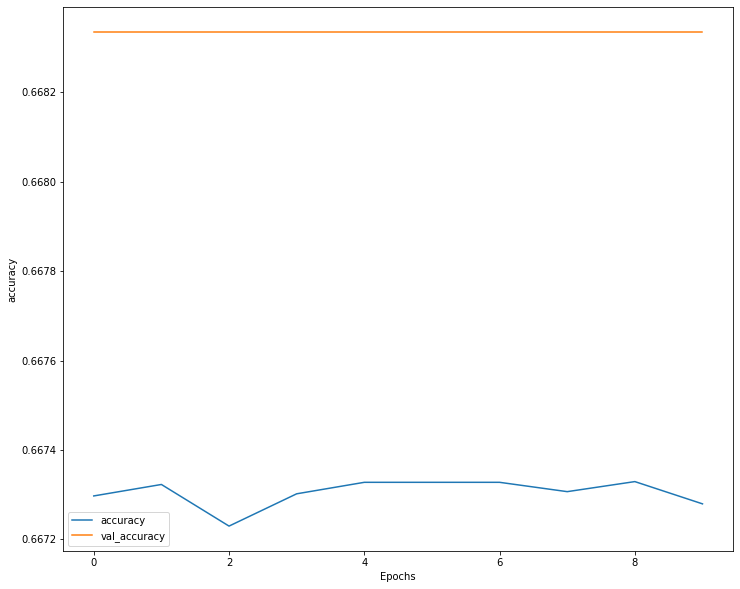

dense_layers :8
RMS :0.1
Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_354 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_355 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_356 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_357 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_358 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_359 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_360 (Dense)           

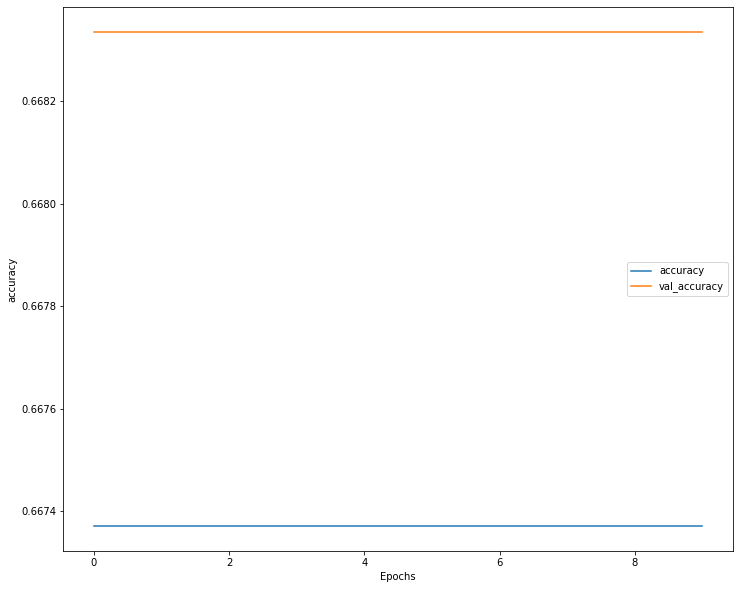

dense_layers :8
RMS :0.1
Model: "sequential_66"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_363 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_364 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_365 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_366 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_367 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_368 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_369 (Dense)           

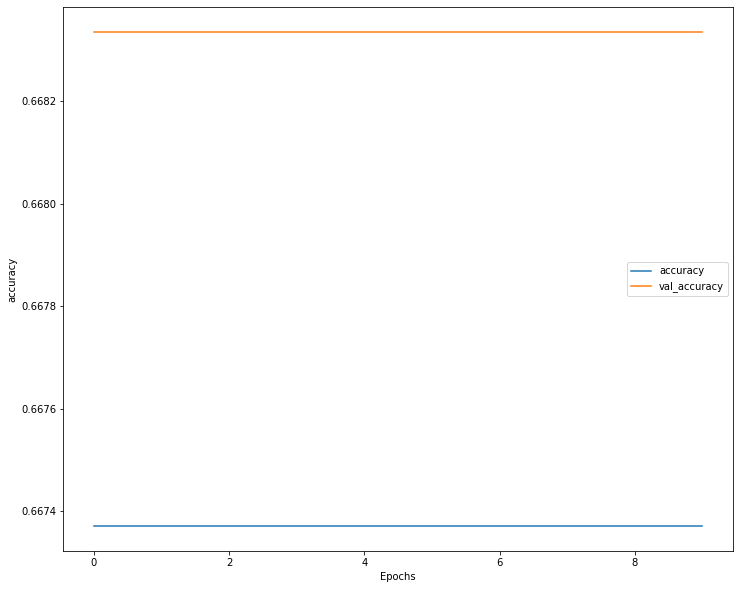

dense_layers :8
RMS :0.1
Model: "sequential_67"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_372 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_373 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_374 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_375 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_376 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_377 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_378 (Dense)           

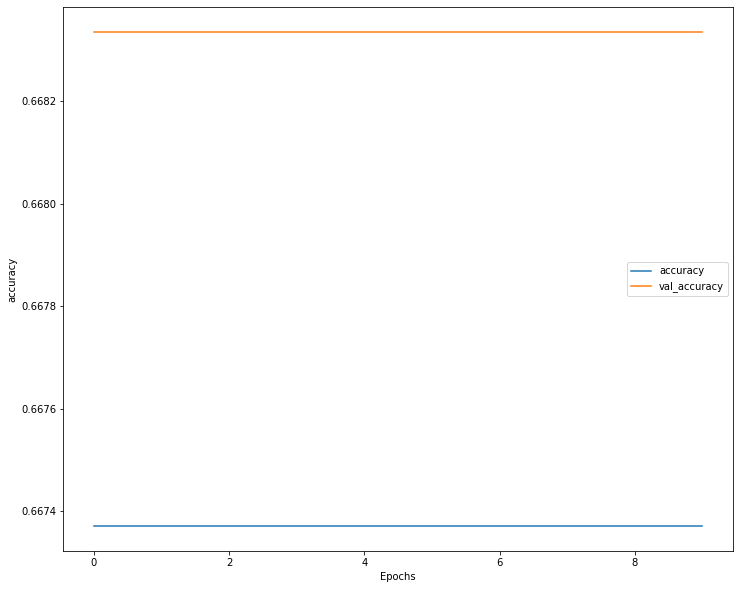

dense_layers :9
RMS :0.01
Model: "sequential_68"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_381 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_382 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_383 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_384 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_385 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_386 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_387 (Dense)          

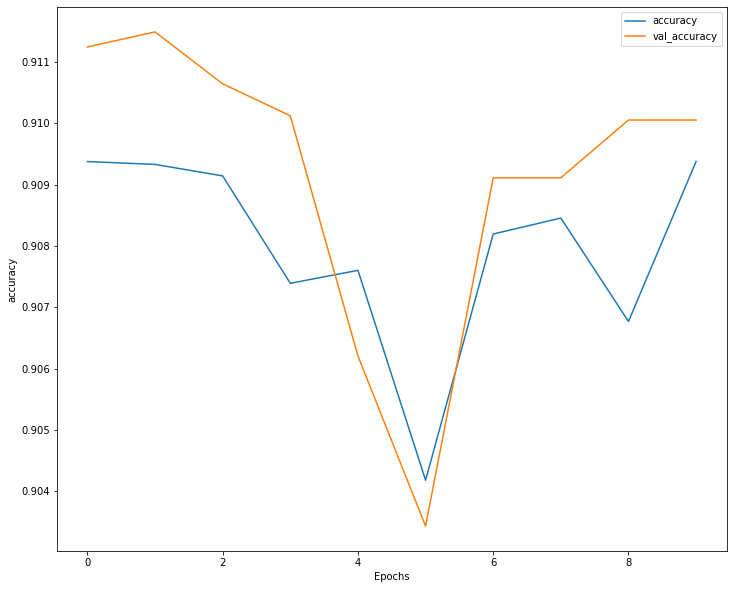

dense_layers :9
RMS :0.01
Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_391 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_392 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_393 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_394 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_395 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_396 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_397 (Dense)          

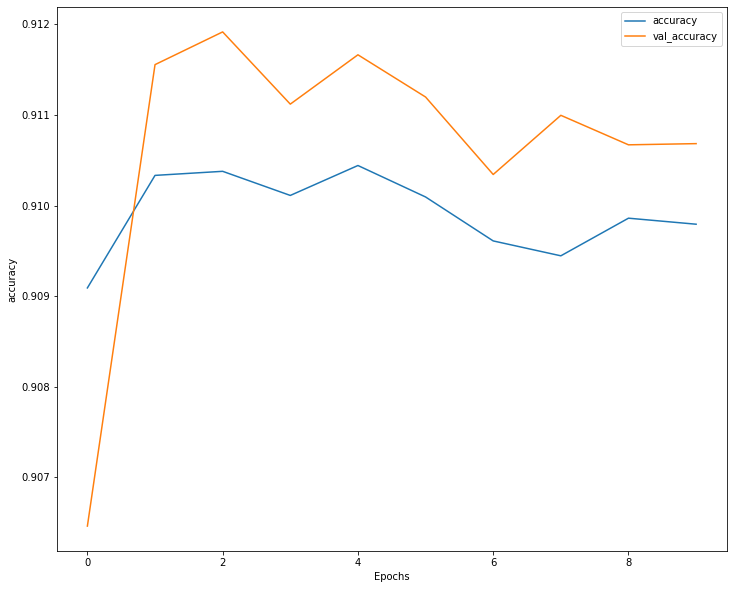

dense_layers :9
RMS :0.01
Model: "sequential_70"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_401 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_402 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_403 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_404 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_405 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_406 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_407 (Dense)          

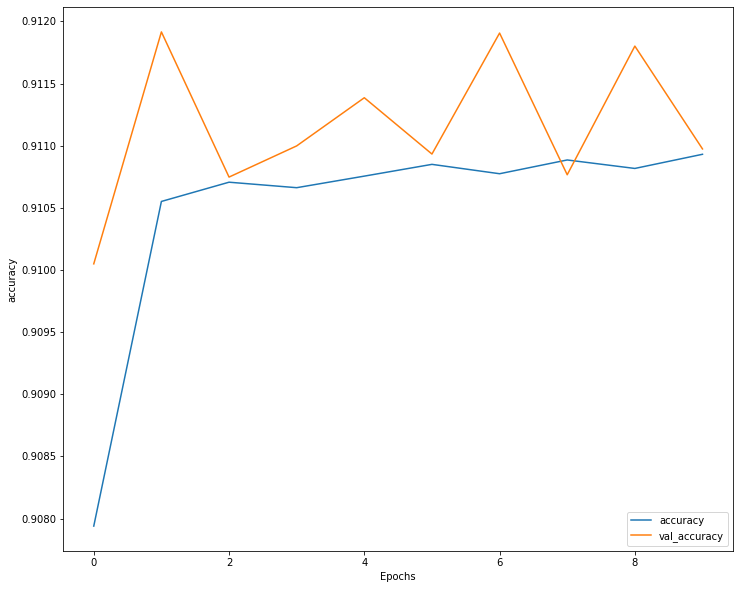

dense_layers :9
RMS :0.01
Model: "sequential_71"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_411 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_412 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_413 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_414 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_415 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_416 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_417 (Dense)          

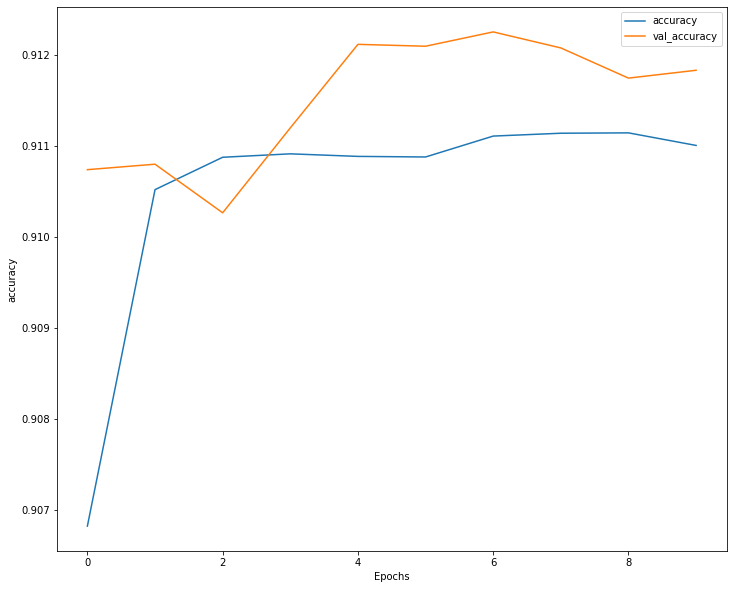

dense_layers :9
RMS :0.1
Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_421 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_422 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_423 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_424 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_425 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_426 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_427 (Dense)           

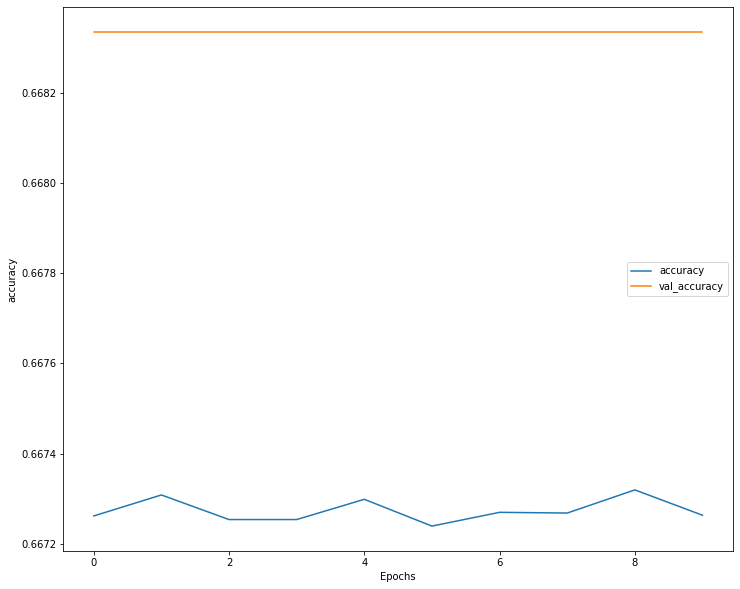

dense_layers :9
RMS :0.1
Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_431 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_432 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_433 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_434 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_435 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_436 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_437 (Dense)           

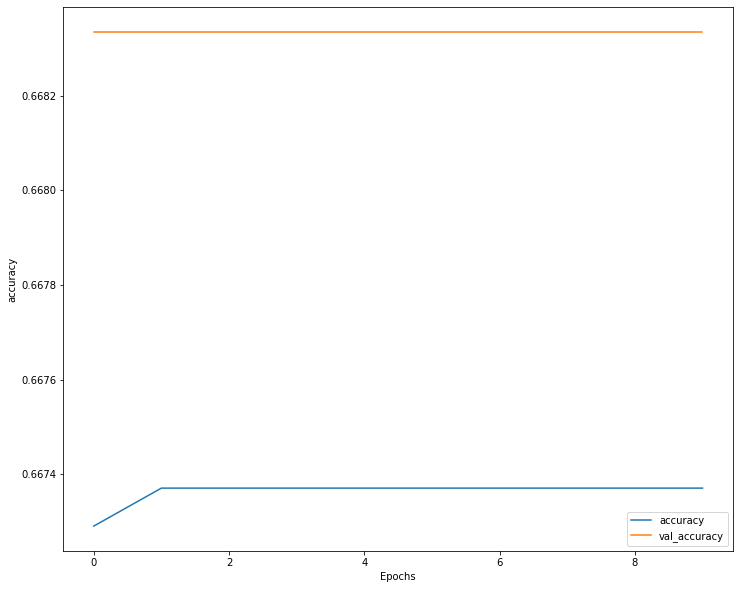

dense_layers :9
RMS :0.1
Model: "sequential_74"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_441 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_442 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_443 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_444 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_445 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_446 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_447 (Dense)           

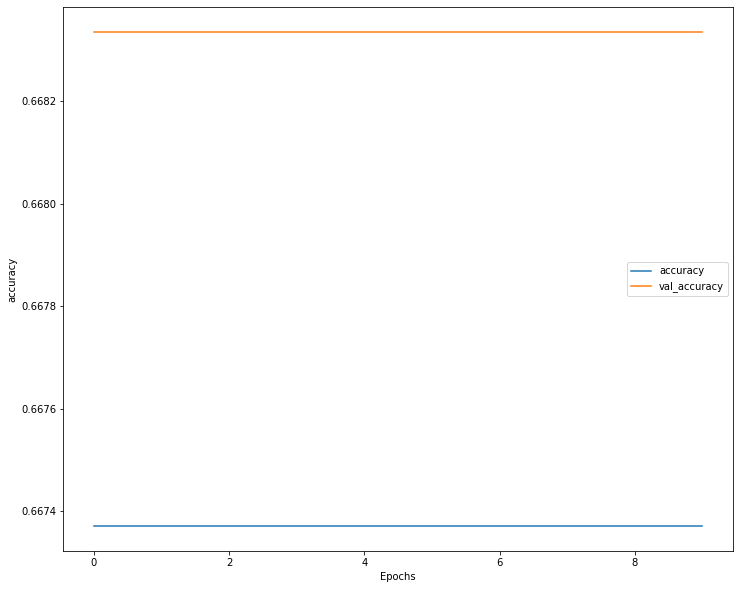

dense_layers :9
RMS :0.1
Model: "sequential_75"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_451 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_452 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_453 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_454 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_455 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_456 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_457 (Dense)           

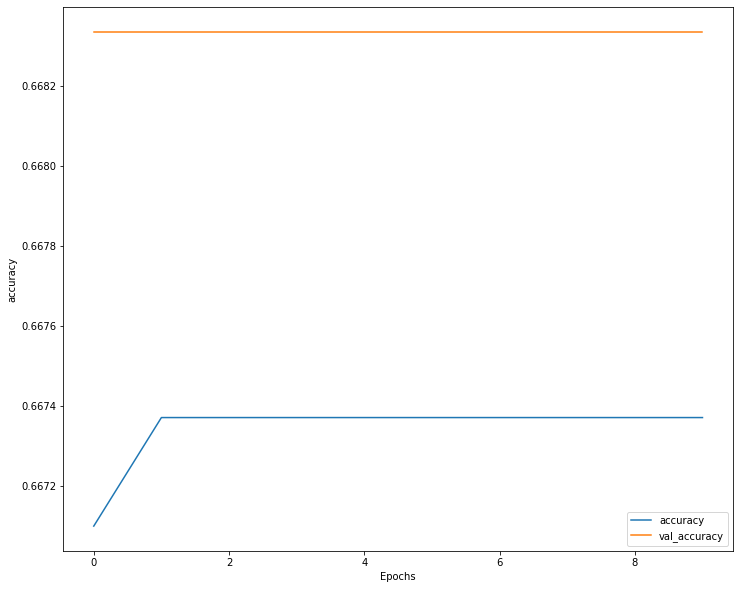

dense_layers :10
RMS :0.01
Model: "sequential_76"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_461 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_462 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_463 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_464 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_465 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_466 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_467 (Dense)         

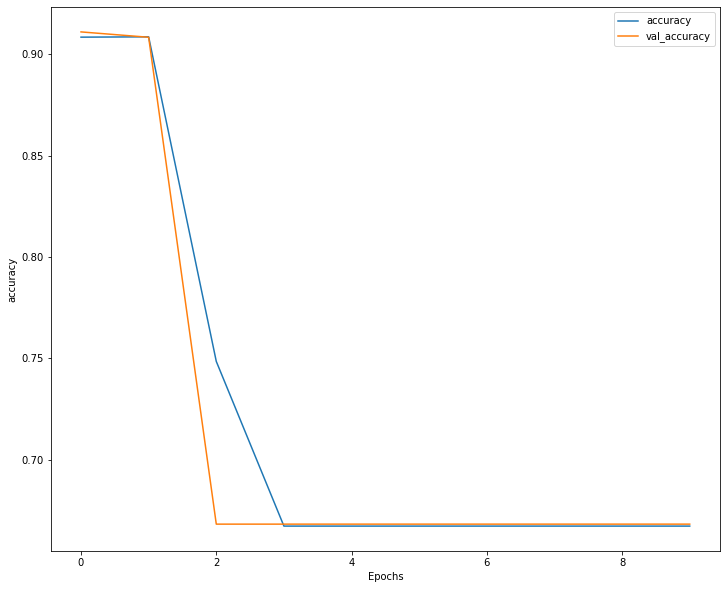

dense_layers :10
RMS :0.01
Model: "sequential_77"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_472 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_473 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_474 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_475 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_476 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_477 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_478 (Dense)         

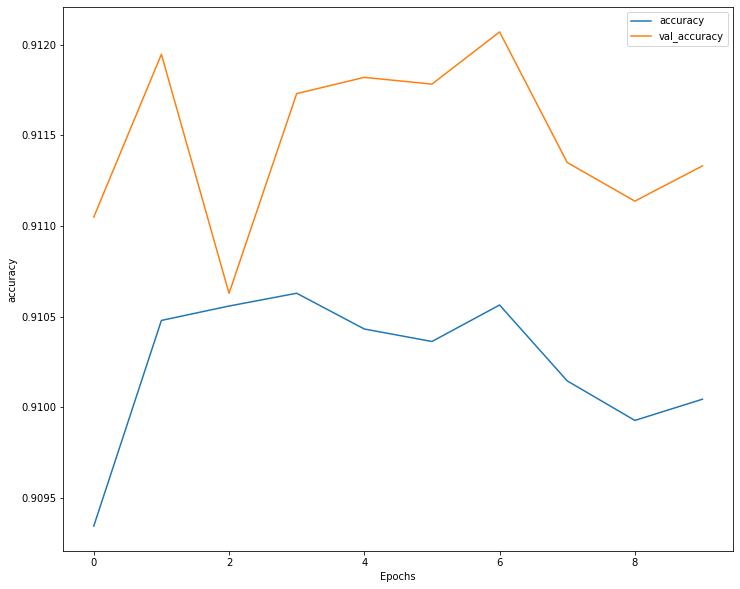

dense_layers :10
RMS :0.01
Model: "sequential_78"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_483 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_484 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_485 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_486 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_487 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_488 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_489 (Dense)         

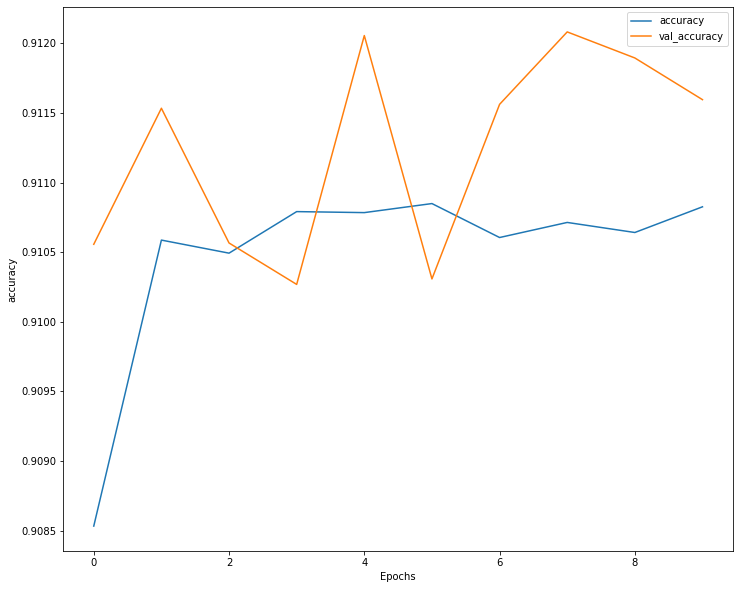

dense_layers :10
RMS :0.01
Model: "sequential_79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_494 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_495 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_496 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_497 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_498 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_499 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_500 (Dense)         

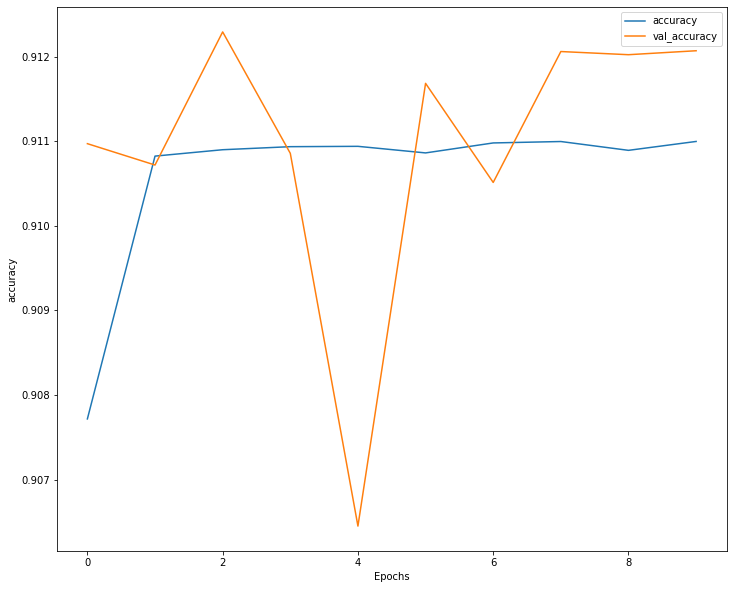

dense_layers :10
RMS :0.1
Model: "sequential_80"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_505 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_506 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_507 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_508 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_509 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_510 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_511 (Dense)          

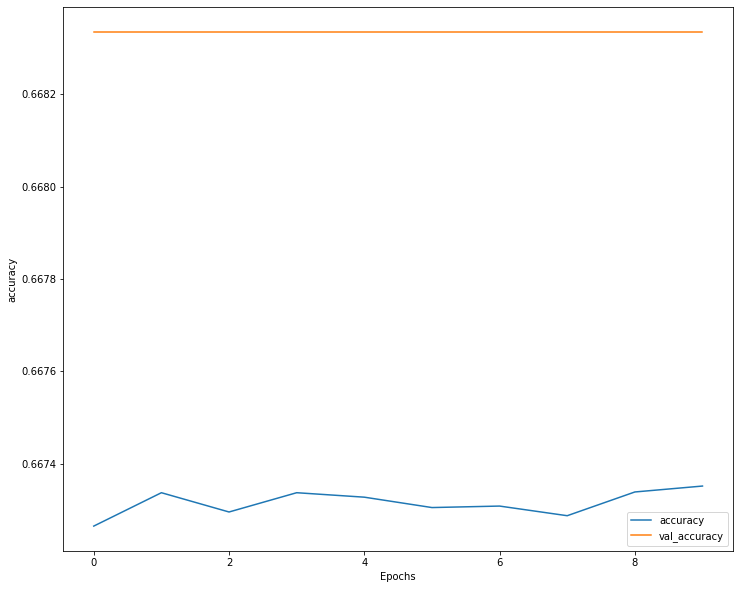

dense_layers :10
RMS :0.1
Model: "sequential_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_516 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_517 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_518 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_519 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_520 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_521 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_522 (Dense)          

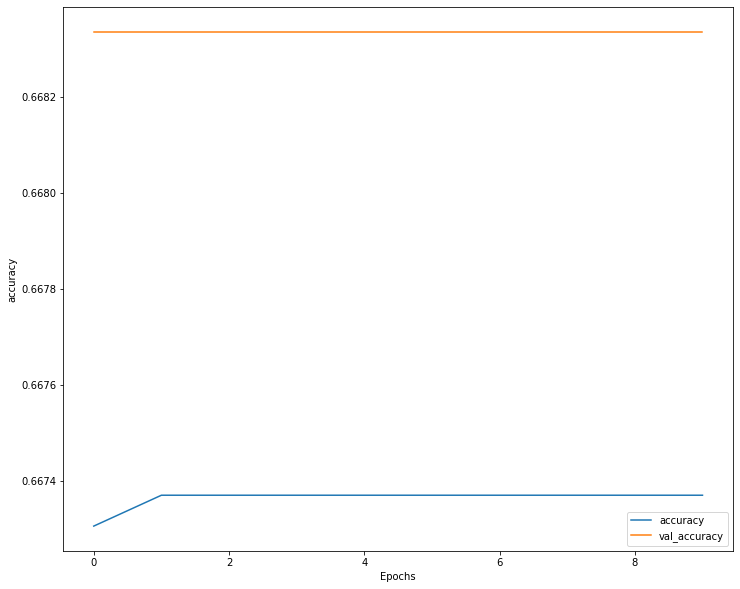

dense_layers :10
RMS :0.1
Model: "sequential_82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_527 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_528 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_529 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_530 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_531 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_532 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_533 (Dense)          

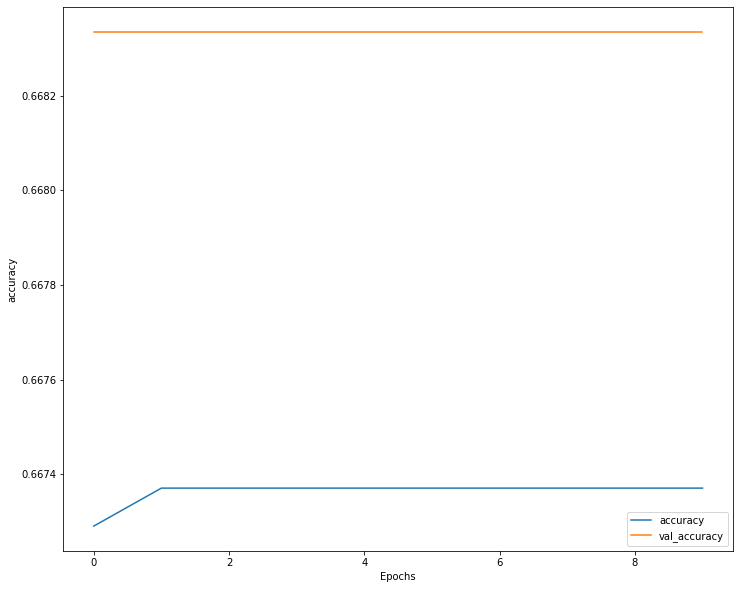

dense_layers :10
RMS :0.1
Model: "sequential_83"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_538 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_539 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_540 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_541 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_542 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_543 (Dense)            (None, 19)                380       
_________________________________________________________________
dense_544 (Dense)          

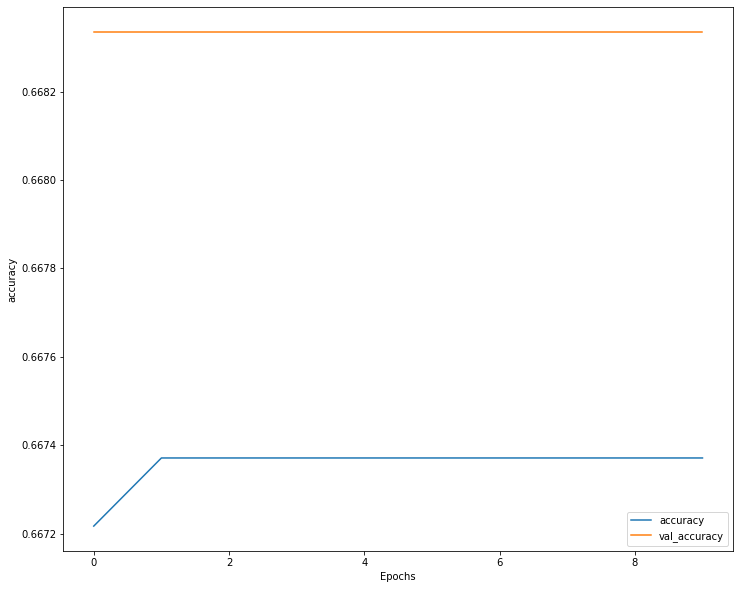

In [33]:
batch_size = [32, 128, 256, 512]
epochs = [10]
dense_layers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
dense_dropout = [0.0, 0.2, 0.5]
RMS = [0.01, 0.1]

# Realiamos un diccionario donde incluimos las listas con los diferentes parámetros del modelo 
import itertools

param_grid = dict(dense_layers = dense_layers
                    , RMS = RMS
                    , batch_size = batch_size
                    , epochs = epochs
                 )

keys = param_grid.keys()
values = (param_grid[key] for key in keys)
param_grid = [dict(zip(keys, param_grid)) for param_grid in itertools.product(*values)]

print('Proposed ' + str(len(param_grid)) + ' models')

for j in range(0, len(param_grid)):
    
    dense_layers = param_grid[j].get("dense_layers")
    RMS = param_grid[j].get("RMS")
    batch_size = param_grid[j].get("batch_size")
    epochs = param_grid[j].get("epochs")
    
    model = make_model(dense_layers = dense_layers
                   , RMS = RMS
                   , batch_size = batch_size
                   , epochs = epochs
                   , verbose = 1)
    
    history = model.fit(train_features,
                        train_labels,
                        batch_size = batch_size,
                        epochs = epochs,
                        validation_data = (val_features, val_labels), 
                        verbose = 0)
    
    plot_history_train(history, 'accuracy')
    accuracy = pd.DataFrame.from_dict(history.history)['accuracy'].iloc[-1]
    param_grid[j].update( {'accuracy':accuracy})
    
results = pd.DataFrame(param_grid)

Creamos un tabla con la precisión (accuracy) ordenada de mayor a menor y los parámetros asociados a cada uno de los modelos

In [34]:
results.sort_values(['accuracy'],ascending = False)

,dense_layers,RMS,batch_size,epochs,accuracy
27,4,0.01,512,10,0.911364
11,2,0.01,512,10,0.911198
3,1,0.01,512,10,0.911152
2,1,0.01,256,10,0.911109
51,7,0.01,512,10,0.911062
...,...,...,...,...,...
44,6,0.10,32,10,0.667278
36,5,0.10,32,10,0.667273
52,7,0.10,32,10,0.667268
68,9,0.10,32,10,0.667264


### Conclusion<a name="conclusion"></a> 
[Volver al índice](#indice)

Según el análisis realizado, los parámetros que permiten obtener una mayor precisión son: 1,2 o 4 capas, un batch size de 256 o 512 y un RMS de 0.01. No obstante, estos resultados pueden sugerir que para estos datos pueden existir mejores modelos que nos den una precisión similar sin necesidad de aplicar una red neuronal. Por ejemplo, una regresión logistica puede ser el modelo más idoneo para identificar cuando un cliente tiene contratada la factura digital.